In [ ]:
#Check gpu
!nvidia-smi

Fri Sep  9 23:57:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    42W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# DataLoader

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms

import random
import os
import numpy as np
import glob
import PIL
from tqdm import tqdm

def rgb2int(arr):
  #From Hex to int:
  return arr[...,0]*(256**2) + arr[...,1]*(256) + arr[...,2]

def rgb2val(color, color2ind):

  int_colors = rgb2int(color)
  int_keys = rgb2int(np.array(list(color2ind.keys()), dtype='uint8'))
  int_array = np.r_[int_colors.ravel(), int_keys] #r_?
  unique, idx = np.unique(int_array, return_inverse=True)
  color_labels = idx[:int_colors.size]
  key_labels = idx[-len(color2ind):]

  colormap = np.empty_like(int_keys, dtype='int32')
  colormap[key_labels] = list(color2ind.values())
  out = colormap[color_labels].reshape(color.shape[:2])

  return out

class TASDataset(Dataset):
  def __init__(self, data_folder, eval=False, mode=None, augment_data=False):
    self.data_folder = data_folder
    self.eval = eval
    self.mode = mode
    self.augment_data = augment_data

    ##ADD AUG

    self.width = 768
    self.height = 384

    self.color2class = {
        #terrain
        (192,192,192): 0, (105,105,105): 0, (160, 82, 45):0, (244,164, 96): 0, \
        #vegatation
        ( 60,179,113): 1, (34,139, 34): 1, ( 154,205, 50): 1, ( 0,128,  0): 1, (0,100,  0):1, ( 0,250,154):1, (139, 69, 19): 1,\
        #construction
        (1, 51, 73):2, ( 190,153,153): 2, ( 0,132,111): 2,\
        #vehicle
        (0,  0,142):3, ( 0, 60,100):3, \
        #sky
        (135,206,250):4,\
        #object
        ( 128,  0,128): 5, (153,153,153):5, (255,255,  0 ):5, \
        #human
        (220, 20, 60):6, \
        #animal
        ( 255,182,193):7,\
        #void
        (220,220,220):8, \
        #undefined
        (0,  0,  0):9}

    self.input_folder = os.path.join(self.data_folder, 'train')
    self.label_folder = os.path.join(self.data_folder, 'train_labels')

    if self.eval:
      self.input_folder = os.path.join(self.data_folder, 'val')
      self.label_folder = os.path.join(self.data_folder, 'val_labels')

    image_names = os.listdir(self.input_folder)

    invalid_labels = ['1537962190852671077.png','1539600515553691119.png', 
                      '1539600738459369245.png','1539600829359771415.png',
                      '1567611260762673589.png']

    if self.mode == 'test':
      image_names = sorted(list(set(image_names).difference(set(invalid_labels))))
    
    else:
      image_names = list(set(image_names).difference(set(invalid_labels)))

    self.paths = [(os.path.join(self.input_folder, i), 
                   os.path.join(self.label_folder, i)) for i in image_names]

    if self.mode == 'val':
      self.paths = self.paths[:50]
    
    elif self.mode == 'test':
      self.paths = self.paths[50:]

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    image = np.asarray(PIL.Image.open(self.paths[idx][0]).resize(
        (self.width, self.height)))
    mask_image = np.asarray(PIL.Image.open(self.paths[idx][1]).resize(
        (self.width, self.height), PIL.Image.NEAREST))
    mask = rgb2val(mask_image, self.color2class)

    image = np.transpose(image, axes=(2,0,1))
    
    
    return image, mask
    ##ADD AUG

#Utils

In [ ]:
import numpy as np
import torch
import torch._C as dtype
from torchvision import transforms
from torch.nn import functional as F
import matplotlib.pyplot as plt

def get_loss_weights(weighting_method=None):
  #Get the loss according to different weighting methods, output == Tensor
  if weighting_method is not None:
    sample_per_class = np.load('sample_per_class.npy')
    print(f"weighting method: {weighting_method}")
  if weighting_method == 'INS': #Inverse Number of Samples
    loss_weights = ins_loss_weights(sample_per_class)
  elif weighting_method == 'ISNS': #Inverse Squared Number of Samples
    loss_weights = ins_loss_weights(sample_per_class, power=0.5)
  elif weighting_method == 'basic':
    loss_weights = basic_loss_weights(sample_per_class)
  else:
    return None
  return loss_weights

def ins_loss_weights(sample_per_class, power=1):
  weights_power = np.power(sample_per_class, power)
  loss_weights = np.sum(weights_power)/weights_power
  loss_weights = loss_weights / 100
  loss_weights = torch.from_numpy(loss_weights)
  return loss_weights

def basic_loss_weights(sample_per_class):
  weights_prop = sample_per_class/sample_per_class.sum()
  loss_weights_inv = 1 - weights_prop
  loss_weights = torch.from_numpy(loss_weights_inv)
  return loss_weights

def iou(pred, target, n_classes=10): #Measure of intersection/union
  ious = []
  pred = pred.view(-1)
  target = target.view(-1)

  #Ignore for class 9 (undefined)
  for cls in range(n_classes-1):
    pred_inds = pred == cls
    target_inds = target == cls

    intersection = (pred_inds*target_inds).sum().item()
    union = pred_inds.sum().item() + target_inds.sum().item() - intersection

    if union == 0:
      ious.append(float('nan')) #Removes frome evaluation if no gt
    else:
      ious.append(intersection/union)
    
  return np.array(ious)

def pixel_acc(pred, target, n_classes=10):

  correct = 0
  total = 0

  pred = pred.view(-1)
  target = target.view(-1)

  for cls in range(n_classes-1):
    pred_inds = pred == cls
    target_inds = target == cls
    correct += (pred_inds*target_inds).sum().item()
    total += target_inds.sum().item()

  return correct/total

def dice_loss(preds, target, eps=1e-7):
  
  num_classes = preds.shape[1]

  #Onehot of classes
  hot = torch.eye(num_classes)[target.squeeze(1)]

  #alter order
  hot = hot.permute(0,3,1,2).float()
  probs = F.softmax(preds, dim=1)

  #Set hot and probs to same type
  hot = hot.type(preds.type())

  #get dims
  dims = (0,) + tuple(range(2, target.ndimension()))

  #calc intersection and union
  intersection = torch.sum(probs*hot, dims)
  union = torch.sum(probs + hot, dims)

  #calc dice
  dice = (2. * intersection / (union + eps)).mean()
  
  #Return dice loss
  return (1 - dice)

def visualize_prediction(image, prediction):

  #Reverse the normalization
  invTrans = transforms.Compose([transforms.Normalize(mean = [0., 0., 0,],
                                                      std = [1/0.229, 1/0.224, 1/0.225]),
                                 transforms.Normalize(mean = [-0.485, -0.456, -0.406],
                                                      std = [1., 1., 1.])])
  
  class2color = {
        #terrain
        0: (192,192,192), \
        #vegatation
        1: ( 60,179,113),\
        #construction
        2: (1, 51, 73),\
        #vehicle
        3: (0,  0,142), \
        #sky
        4: (135,206,250),\
        #object
        5: ( 128,  0,128), \
        #human
        6: (220, 20, 60), \
        #animal
        7: ( 255,182,193),\
        #void
        8: (220,220,220), \
        #undefined
        9: (0,  0,  0)
  }

  img_copy = torch.detach(image).clone()
  img_copy = img_copy.cpu()
  img_copy = invTrans(img_copy)
  img_copy = img_copy.permute(1,2,0).numpy()
  pred_copy = torch.detach(prediction).clone()
  pred_copy = pred_copy.cpu()
  pred_copy = pred_copy.numpy()

  segmentation_mask = np.zeros((pred_copy.shape[0], pred_copy.shape[1], 3), dtype=int)
  for c in range(10):
    pred_ind = pred_copy == c
    segmentation_mask[pred_ind] = class2color[c]

  plt.figure()
  plt.imshow(img_copy, interpolation='none')
  plt.imshow(segmentation_mask, alpha=0.5, interpolation='none')
  plt.savefig('segmented_test_img.png')

#The Model

In [ ]:
import torch.nn as nn

def double_conv_block(in_channels, out_channels, batch_norm):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(batch_norm), nn.ReLU(inplace=True), nn.Dropout(p=.2),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(batch_norm), nn.ReLU(inplace=True), nn.Dropout(p=.2))

class UNet(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    self.n_class = num_classes
    self.pool = nn.MaxPool2d(2, stride=2)

    #Encoder
    self.enc1 = double_conv_block(3, 64, 64)
    self.enc2 = double_conv_block(64, 128, 128)
    self.enc3 = double_conv_block(128, 256, 256)
    self.enc4 = double_conv_block(256, 512, 512)
    self.enc5 = double_conv_block(512, 1024, 1024)

    #Decoder
    self.tran1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
    self.dec1 = double_conv_block(1024, 512, 512)
    self.tran2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    self.dec2 = double_conv_block(512, 256, 256)
    self.tran3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.dec3 = double_conv_block(256, 128, 128)
    self.tran4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.dec4 = double_conv_block(128, 64, 64)

    #Output
    self.classifier = nn.Conv2d(64, self.n_class, kernel_size=1, padding=0)

  def forward(self, x):

    #Encode
    enc_out1 = self.enc1(x)
    enc_pool1 = self.pool(enc_out1)
    enc_out2 = self.enc2(enc_pool1)
    enc_pool2 = self.pool(enc_out2)
    enc_out3 = self.enc3(enc_pool2)
    enc_pool3 = self.pool(enc_out3)
    enc_out4 = self.enc4(enc_pool3)
    enc_pool4 = self.pool(enc_out4)
    enc_out5 = self.enc5(enc_pool4)

    #Decode
    deco1 = self.tran1(enc_out5)
    cat1 = torch.cat([enc_out4, deco1], dim=1)
    dec_out1 = self.dec1(cat1)

    deco2 = self.tran2(dec_out1)
    cat2 = torch.cat([enc_out3, deco2], dim=1)
    dec_out2 = self.dec2(cat2)

    deco3 = self.tran3(dec_out2)
    cat3 = torch.cat([enc_out2, deco3], dim=1)
    dec_out3 = self.dec3(cat3)

    deco4 = self.tran4(dec_out3)
    cat4 = torch.cat([enc_out1, deco4], dim=1)
    dec_out4 = self.dec4(cat4)

    return self.classifier(dec_out4)

#Model Initialization

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import time
import numpy as np

#How to deal with data?

def init_weights(layer):
  if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
    nn.init.xavier_uniform_(layer.weight.data)
    nn.init.normal_(layer.bias.data)

#Initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4
epochs = 100
no_improvement = 0 #N epochs without improvement prior to counting
epoch_stop = 30 #N epochs counted before stopping
n_class = 10
lr = 3e-4

#Initialize model
model = UNet(num_classes=n_class)
model.apply(init_weights)
criterion = dice_loss
optimizer = optim.AdamW(model.parameters(), lr=lr)
model = model.to(device)

print(next(model.parameters()).is_cuda)

True


# Data Initialization

In [ ]:
Data_PATH = 'REPLACE HERE with own data path' 

#Change this for transformations
augment_data = False

train_dataset = TASDataset(Data_PATH, augment_data=augment_data)
val_dataset = TASDataset(Data_PATH, eval=True, mode='val')
test_dataset = TASDataset(Data_PATH, eval=True, mode='test')

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Train and Validation

In [ ]:
def train():

  best_miou_score = 0
  best_loss = 0
  best_acc = 0
  train_losses = []
  val_losses = []
  accs = []

  for epoch in range(epochs):

    ts = time.time()
    model.train()

    for iter, (inputs, labels) in enumerate(train_loader):
      
      losses = []
      labels = labels.long()
      inputs = inputs.float()
      
      optimizer.zero_grad()

      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      
      with torch.no_grad():
        loss.backward()
        optimizer.step()

      #Save loss
      loss_cpu = loss.to('cpu')
      losses.append(loss_cpu.item())

      if iter % 10 == 0:
        print(f"epoch {epoch}, iter {iter}, loss: {loss_cpu.item()}")
      
    train_losses.append(np.mean(np.array(losses)))
    print(f'Finished epoch {epoch}, time elapsed: {time.time() - ts}')

    current_miou_score, current_acc, current_loss = val(epoch)
    val_losses.append(current_loss)
    accs.append(current_acc)
    
    if current_miou_score > best_miou_score:
      best_miou_score = current_miou_score
      best_loss = current_loss
      best_acc = current_acc

      epoch_no_imp = 0
      torch.save(model.state_dict(), f'model.pth')
    
    else:
      epoch_no_imp += 1
      print(f'No improvements for {epoch_no_imp} rounds.')

      if epoch_no_imp >= epoch_stop:
        print(f'No improvement for {epoch_stop} rounds.')
        print(f'iou:{best_miou_score}, pixel_acc: {best_acc}, loss: {best_loss}.')
        break
  
    plt.plot(train_losses,"-b", label="Training Loss")
    plt.plot(val_losses,"-r", label="Validation Loss")
    plt.plot(accs,"-g", label="Pixel Accuracy")
    plt.locator_params(axis="x", integer=True, tight=True)
    plt.xlabel("Epoch")
    plt.ylabel("Losses and Accuracy")
    plt.title("Training/Validation Loss and Validation Accuracy")
    plt.legend(loc="upper right")
    plt.show()
  
  return train_losses, val_losses, accs

def val(epoch):
  
  model.eval()

  losses = []
  mean_iou_scores = []
  accs = []

  with torch.no_grad():
    for iter, (input, label) in enumerate(val_loader):
      label = label.long()
      input = input.float()
      input = input.to(device)
      label = label.to(device)
      
      output = model(input)
      loss = criterion(output, label)
      loss_cpu = loss.to('cpu')

      losses.append(loss_cpu)
      pred = torch.argmax(output, dim=1)

      mean_iou_scores.append(np.nanmean(iou(pred, label, n_class)))
      accs.append(pixel_acc(pred,label))
  
  print(f'Loss at epoch {epoch}: {np.mean(losses)}')
  print(f'IoU at epoch {epoch}: {np.mean(mean_iou_scores)}')
  print(f'Pixel acc at epoch {epoch}: {np.mean(accs)}')
  return np.mean(mean_iou_scores), np.mean(accs), np.mean(losses)

#Implement test

#Trial runs

/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/collate.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  return default_collate([torch.as_tensor(b) for b in batch])


epoch 0, iter 0, loss: 0.9526882767677307
epoch 0, iter 10, loss: 0.8755429983139038
epoch 0, iter 20, loss: 0.8863592147827148
epoch 0, iter 30, loss: 0.8712682127952576
epoch 0, iter 40, loss: 0.8551982641220093
epoch 0, iter 50, loss: 0.7895833849906921
epoch 0, iter 60, loss: 0.7766090631484985
epoch 0, iter 70, loss: 0.7444111108779907
epoch 0, iter 80, loss: 0.7217189073562622
epoch 0, iter 90, loss: 0.7768509387969971
epoch 0, iter 100, loss: 0.7755346894264221
Finished epoch 0, time elapsed: 101.08604955673218
Loss at epoch 0: 0.7496572136878967
IoU at epoch 0: 0.3211814817810782
Pixel acc at epoch 0: 0.644129484825641


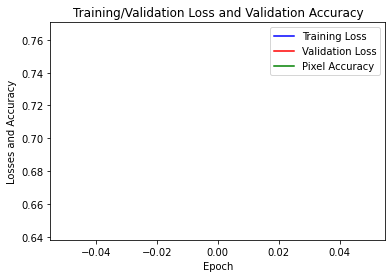

epoch 1, iter 0, loss: 0.7663213014602661
epoch 1, iter 10, loss: 0.7080469727516174
epoch 1, iter 20, loss: 0.7217209935188293
epoch 1, iter 30, loss: 0.7455114126205444
epoch 1, iter 40, loss: 0.7759709358215332
epoch 1, iter 50, loss: 0.7490952014923096
epoch 1, iter 60, loss: 0.760420560836792
epoch 1, iter 70, loss: 0.7706834673881531
epoch 1, iter 80, loss: 0.6914121508598328
epoch 1, iter 90, loss: 0.6702659130096436
epoch 1, iter 100, loss: 0.7520933747291565
Finished epoch 1, time elapsed: 98.98517942428589
Loss at epoch 1: 0.7405215501785278
IoU at epoch 1: 0.3288837901369191
Pixel acc at epoch 1: 0.6539005717551635


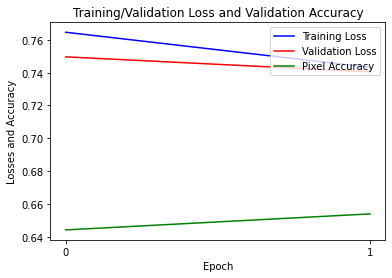

epoch 2, iter 0, loss: 0.7104334235191345
epoch 2, iter 10, loss: 0.6994796991348267
epoch 2, iter 20, loss: 0.7506498694419861
epoch 2, iter 30, loss: 0.7470186948776245
epoch 2, iter 40, loss: 0.7195843458175659
epoch 2, iter 50, loss: 0.7357479333877563
epoch 2, iter 60, loss: 0.6865078806877136
epoch 2, iter 70, loss: 0.6957418918609619
epoch 2, iter 80, loss: 0.7041211128234863
epoch 2, iter 90, loss: 0.6638718843460083
epoch 2, iter 100, loss: 0.6927586197853088
Finished epoch 2, time elapsed: 99.47731590270996
Loss at epoch 2: 0.7965232133865356
IoU at epoch 2: 0.2504992436058373
Pixel acc at epoch 2: 0.6680819498289426
No improvements for 1 rounds.


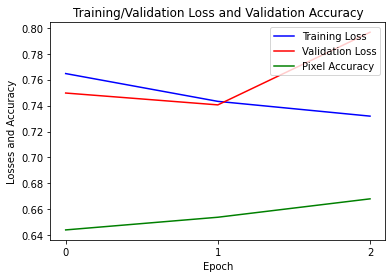

epoch 3, iter 0, loss: 0.6716387867927551
epoch 3, iter 10, loss: 0.6835567951202393
epoch 3, iter 20, loss: 0.6982338428497314
epoch 3, iter 30, loss: 0.7231055498123169
epoch 3, iter 40, loss: 0.6735165119171143
epoch 3, iter 50, loss: 0.6750528812408447
epoch 3, iter 60, loss: 0.6959739923477173
epoch 3, iter 70, loss: 0.7077391743659973
epoch 3, iter 80, loss: 0.7714207172393799
epoch 3, iter 90, loss: 0.6904377937316895
epoch 3, iter 100, loss: 0.7369225025177002
Finished epoch 3, time elapsed: 99.39923930168152
Loss at epoch 3: 0.7043254375457764
IoU at epoch 3: 0.40202086213428867
Pixel acc at epoch 3: 0.807528434023327


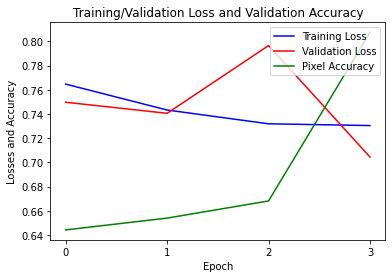

epoch 4, iter 0, loss: 0.684910774230957
epoch 4, iter 10, loss: 0.6518790125846863
epoch 4, iter 20, loss: 0.6775998473167419
epoch 4, iter 30, loss: 0.7770512104034424
epoch 4, iter 40, loss: 0.6936318874359131
epoch 4, iter 50, loss: 0.6504878401756287
epoch 4, iter 60, loss: 0.6495895981788635
epoch 4, iter 70, loss: 0.6926597952842712
epoch 4, iter 80, loss: 0.8219715356826782
epoch 4, iter 90, loss: 0.7492712736129761
epoch 4, iter 100, loss: 0.7545055150985718
Finished epoch 4, time elapsed: 99.21511125564575
Loss at epoch 4: 0.7105362415313721
IoU at epoch 4: 0.38315656472681625
Pixel acc at epoch 4: 0.7283641397286028
No improvements for 1 rounds.


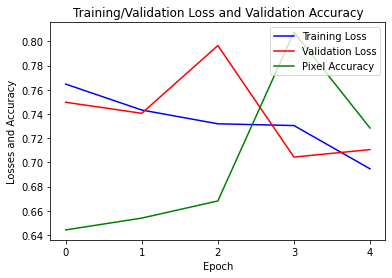

epoch 5, iter 0, loss: 0.7017794847488403
epoch 5, iter 10, loss: 0.7004731297492981
epoch 5, iter 20, loss: 0.6956846117973328
epoch 5, iter 30, loss: 0.6462662220001221
epoch 5, iter 40, loss: 0.687760055065155
epoch 5, iter 50, loss: 0.6804473400115967
epoch 5, iter 60, loss: 0.7251955270767212
epoch 5, iter 70, loss: 0.6726952791213989
epoch 5, iter 80, loss: 0.7002991437911987
epoch 5, iter 90, loss: 0.6882970929145813
epoch 5, iter 100, loss: 0.7052374482154846
Finished epoch 5, time elapsed: 99.20643973350525
Loss at epoch 5: 0.7072269916534424
IoU at epoch 5: 0.3738578456207525
Pixel acc at epoch 5: 0.7907077477966435
No improvements for 2 rounds.


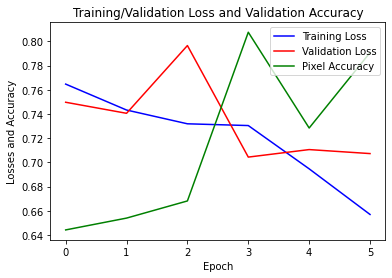

epoch 6, iter 0, loss: 0.7224096059799194
epoch 6, iter 10, loss: 0.6462912559509277
epoch 6, iter 20, loss: 0.6756071448326111
epoch 6, iter 30, loss: 0.6337202787399292
epoch 6, iter 40, loss: 0.7009056806564331
epoch 6, iter 50, loss: 0.6823400259017944
epoch 6, iter 60, loss: 0.6677442789077759
epoch 6, iter 70, loss: 0.6548008322715759
epoch 6, iter 80, loss: 0.6521815657615662
epoch 6, iter 90, loss: 0.6597970128059387
epoch 6, iter 100, loss: 0.6240572333335876
Finished epoch 6, time elapsed: 99.27896451950073
Loss at epoch 6: 0.7074206471443176
IoU at epoch 6: 0.36711642197602296
Pixel acc at epoch 6: 0.8126006490823416
No improvements for 3 rounds.


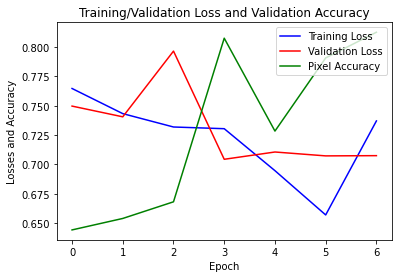

epoch 7, iter 0, loss: 0.7750342488288879
epoch 7, iter 10, loss: 0.6815026998519897
epoch 7, iter 20, loss: 0.6506235003471375
epoch 7, iter 30, loss: 0.6740425825119019
epoch 7, iter 40, loss: 0.6943056583404541
epoch 7, iter 50, loss: 0.6758977174758911
epoch 7, iter 60, loss: 0.6447442770004272
epoch 7, iter 70, loss: 0.6375415325164795
epoch 7, iter 80, loss: 0.7071661949157715
epoch 7, iter 90, loss: 0.6713446974754333
epoch 7, iter 100, loss: 0.6970065236091614
Finished epoch 7, time elapsed: 99.52077507972717
Loss at epoch 7: 0.6803549528121948
IoU at epoch 7: 0.43685299229606933
Pixel acc at epoch 7: 0.8347246245491694


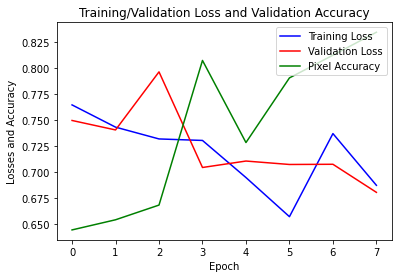

epoch 8, iter 0, loss: 0.65605628490448
epoch 8, iter 10, loss: 0.645439088344574
epoch 8, iter 20, loss: 0.6840280294418335
epoch 8, iter 30, loss: 0.6375700235366821
epoch 8, iter 40, loss: 0.671724796295166
epoch 8, iter 50, loss: 0.6857277154922485
epoch 8, iter 60, loss: 0.5842940211296082
epoch 8, iter 70, loss: 0.6881617307662964
epoch 8, iter 80, loss: 0.6891796588897705
epoch 8, iter 90, loss: 0.6519533395767212
epoch 8, iter 100, loss: 0.6952234506607056
Finished epoch 8, time elapsed: 99.34707713127136
Loss at epoch 8: 0.6946773529052734
IoU at epoch 8: 0.40157137290735173
Pixel acc at epoch 8: 0.8347839397884843
No improvements for 1 rounds.


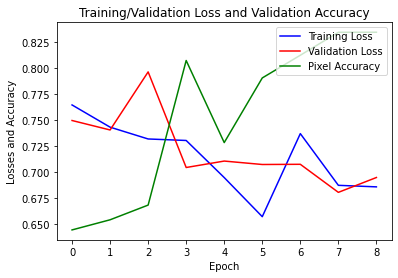

epoch 9, iter 0, loss: 0.6418701410293579
epoch 9, iter 10, loss: 0.605708122253418
epoch 9, iter 20, loss: 0.6801406741142273
epoch 9, iter 30, loss: 0.6706963777542114
epoch 9, iter 40, loss: 0.6396181583404541
epoch 9, iter 50, loss: 0.712246298789978
epoch 9, iter 60, loss: 0.654328465461731
epoch 9, iter 70, loss: 0.7212746143341064
epoch 9, iter 80, loss: 0.6580812931060791
epoch 9, iter 90, loss: 0.6728779673576355
epoch 9, iter 100, loss: 0.61722731590271
Finished epoch 9, time elapsed: 99.21912217140198
Loss at epoch 9: 0.710923433303833
IoU at epoch 9: 0.3860882285048556
Pixel acc at epoch 9: 0.7760642105308589
No improvements for 2 rounds.


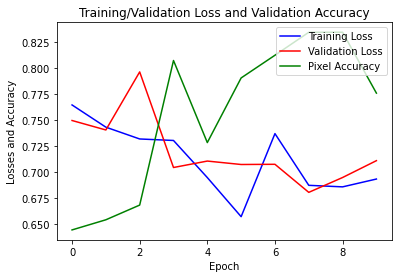

epoch 10, iter 0, loss: 0.6489244699478149
epoch 10, iter 10, loss: 0.6635280847549438
epoch 10, iter 20, loss: 0.5847861766815186
epoch 10, iter 30, loss: 0.6574137210845947
epoch 10, iter 40, loss: 0.7024096250534058
epoch 10, iter 50, loss: 0.6596062183380127
epoch 10, iter 60, loss: 0.7284469604492188
epoch 10, iter 70, loss: 0.7008755803108215
epoch 10, iter 80, loss: 0.6763408184051514
epoch 10, iter 90, loss: 0.6459509134292603
epoch 10, iter 100, loss: 0.6694588661193848
Finished epoch 10, time elapsed: 99.1869375705719
Loss at epoch 10: 0.729101300239563
IoU at epoch 10: 0.34616591431507737
Pixel acc at epoch 10: 0.799891253791575
No improvements for 3 rounds.


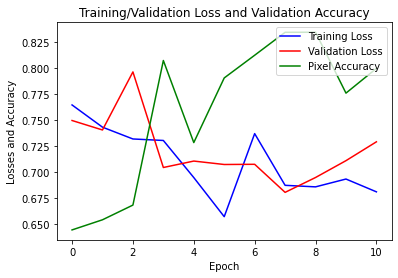

epoch 11, iter 0, loss: 0.6235315799713135
epoch 11, iter 10, loss: 0.6409871578216553
epoch 11, iter 20, loss: 0.6564915180206299
epoch 11, iter 30, loss: 0.6615022420883179
epoch 11, iter 40, loss: 0.6072241067886353
epoch 11, iter 50, loss: 0.6355030536651611
epoch 11, iter 60, loss: 0.6886223554611206
epoch 11, iter 70, loss: 0.6753772497177124
epoch 11, iter 80, loss: 0.6819596886634827
epoch 11, iter 90, loss: 0.6539759635925293
epoch 11, iter 100, loss: 0.6486649513244629
Finished epoch 11, time elapsed: 99.31072330474854
Loss at epoch 11: 0.7436500787734985
IoU at epoch 11: 0.3197954399630448
Pixel acc at epoch 11: 0.7822849306938612
No improvements for 4 rounds.


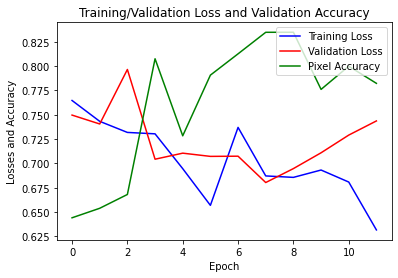

epoch 12, iter 0, loss: 0.6902286410331726
epoch 12, iter 10, loss: 0.608311116695404
epoch 12, iter 20, loss: 0.6150652766227722
epoch 12, iter 30, loss: 0.705024778842926
epoch 12, iter 40, loss: 0.6606799364089966
epoch 12, iter 50, loss: 0.6413513422012329
epoch 12, iter 60, loss: 0.6174918413162231
epoch 12, iter 70, loss: 0.635209858417511
epoch 12, iter 80, loss: 0.6955384016036987
epoch 12, iter 90, loss: 0.6506751179695129
epoch 12, iter 100, loss: 0.6726853847503662
Finished epoch 12, time elapsed: 99.5045223236084
Loss at epoch 12: 0.6778717637062073
IoU at epoch 12: 0.4405903455902345
Pixel acc at epoch 12: 0.8555144353753439


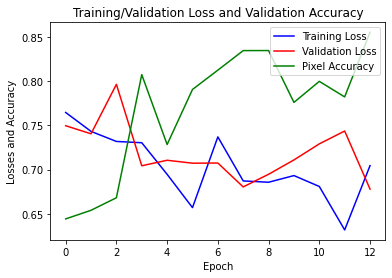

epoch 13, iter 0, loss: 0.736788272857666
epoch 13, iter 10, loss: 0.6802403926849365
epoch 13, iter 20, loss: 0.6490965485572815
epoch 13, iter 30, loss: 0.64976966381073
epoch 13, iter 40, loss: 0.6560819149017334
epoch 13, iter 50, loss: 0.658098578453064
epoch 13, iter 60, loss: 0.6701769232749939
epoch 13, iter 70, loss: 0.6458075642585754
epoch 13, iter 80, loss: 0.6526632905006409
epoch 13, iter 90, loss: 0.6764048337936401
epoch 13, iter 100, loss: 0.6679425835609436
Finished epoch 13, time elapsed: 99.45698595046997
Loss at epoch 13: 0.6612976789474487
IoU at epoch 13: 0.4606167956013294
Pixel acc at epoch 13: 0.8563831311287908


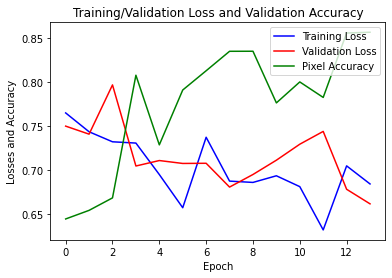

epoch 14, iter 0, loss: 0.6849561929702759
epoch 14, iter 10, loss: 0.6850706338882446
epoch 14, iter 20, loss: 0.6038548946380615
epoch 14, iter 30, loss: 0.6877104043960571
epoch 14, iter 40, loss: 0.6097233295440674
epoch 14, iter 50, loss: 0.6280449628829956
epoch 14, iter 60, loss: 0.6463534832000732
epoch 14, iter 70, loss: 0.5980784893035889
epoch 14, iter 80, loss: 0.6754015684127808
epoch 14, iter 90, loss: 0.6477583050727844
epoch 14, iter 100, loss: 0.6747669577598572
Finished epoch 14, time elapsed: 99.49000430107117
Loss at epoch 14: 0.6692184209823608
IoU at epoch 14: 0.4486157617847407
Pixel acc at epoch 14: 0.8399941594164357
No improvements for 1 rounds.


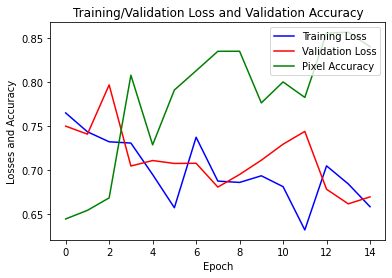

epoch 15, iter 0, loss: 0.6756531596183777
epoch 15, iter 10, loss: 0.6608914136886597
epoch 15, iter 20, loss: 0.6482322812080383
epoch 15, iter 30, loss: 0.6721773147583008
epoch 15, iter 40, loss: 0.6236951351165771
epoch 15, iter 50, loss: 0.6027868986129761
epoch 15, iter 60, loss: 0.633702278137207
epoch 15, iter 70, loss: 0.634697675704956
epoch 15, iter 80, loss: 0.653968095779419
epoch 15, iter 90, loss: 0.6093957424163818
epoch 15, iter 100, loss: 0.6218727827072144
Finished epoch 15, time elapsed: 99.41940975189209
Loss at epoch 15: 0.659626305103302
IoU at epoch 15: 0.4704970810189867
Pixel acc at epoch 15: 0.864871616828429


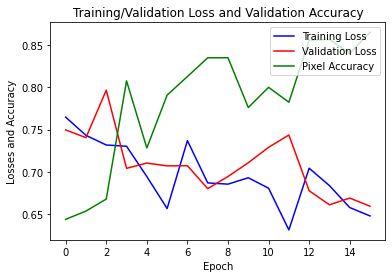

epoch 16, iter 0, loss: 0.6469699144363403
epoch 16, iter 10, loss: 0.6638215780258179
epoch 16, iter 20, loss: 0.6942447423934937
epoch 16, iter 30, loss: 0.6345536708831787
epoch 16, iter 40, loss: 0.6664420366287231
epoch 16, iter 50, loss: 0.6996134519577026
epoch 16, iter 60, loss: 0.6710504293441772
epoch 16, iter 70, loss: 0.6513926982879639
epoch 16, iter 80, loss: 0.6177915930747986
epoch 16, iter 90, loss: 0.6017364263534546
epoch 16, iter 100, loss: 0.654708743095398
Finished epoch 16, time elapsed: 98.96194553375244
Loss at epoch 16: 0.6689040660858154
IoU at epoch 16: 0.44590327044928296
Pixel acc at epoch 16: 0.8231836504107084
No improvements for 1 rounds.


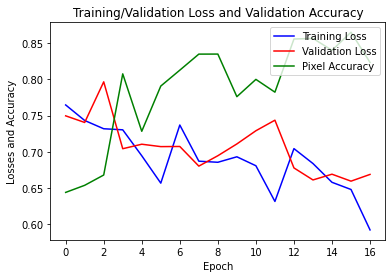

epoch 17, iter 0, loss: 0.6502379179000854
epoch 17, iter 10, loss: 0.6432226896286011
epoch 17, iter 20, loss: 0.6051312685012817
epoch 17, iter 30, loss: 0.629027247428894
epoch 17, iter 40, loss: 0.6782524585723877
epoch 17, iter 50, loss: 0.5930231809616089
epoch 17, iter 60, loss: 0.6277015209197998
epoch 17, iter 70, loss: 0.6586376428604126
epoch 17, iter 80, loss: 0.6297013759613037
epoch 17, iter 90, loss: 0.600163459777832
epoch 17, iter 100, loss: 0.6548488140106201
Finished epoch 17, time elapsed: 98.93170619010925
Loss at epoch 17: 0.672052800655365
IoU at epoch 17: 0.4427610471118951
Pixel acc at epoch 17: 0.8178217950779006
No improvements for 2 rounds.


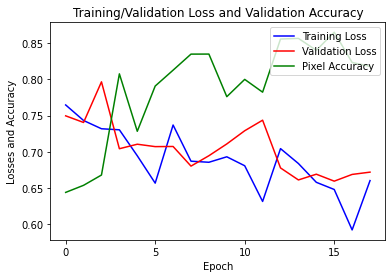

epoch 18, iter 0, loss: 0.6727951765060425
epoch 18, iter 10, loss: 0.6351099014282227
epoch 18, iter 20, loss: 0.6599558591842651
epoch 18, iter 30, loss: 0.6268911361694336
epoch 18, iter 40, loss: 0.7301774621009827
epoch 18, iter 50, loss: 0.6592618823051453
epoch 18, iter 60, loss: 0.6645975708961487
epoch 18, iter 70, loss: 0.5677617192268372
epoch 18, iter 80, loss: 0.6148532629013062
epoch 18, iter 90, loss: 0.6665531396865845
epoch 18, iter 100, loss: 0.6442810297012329
Finished epoch 18, time elapsed: 99.08832573890686
Loss at epoch 18: 0.6659719944000244
IoU at epoch 18: 0.4563440471415235
Pixel acc at epoch 18: 0.8396175442726465
No improvements for 3 rounds.


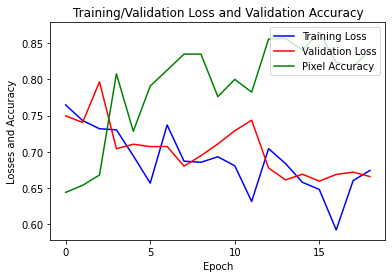

epoch 19, iter 0, loss: 0.6029716730117798
epoch 19, iter 10, loss: 0.6320503950119019
epoch 19, iter 20, loss: 0.6388154029846191
epoch 19, iter 30, loss: 0.6296298503875732
epoch 19, iter 40, loss: 0.6848178505897522
epoch 19, iter 50, loss: 0.7417950630187988
epoch 19, iter 60, loss: 0.6284209489822388
epoch 19, iter 70, loss: 0.6248512268066406
epoch 19, iter 80, loss: 0.6983439326286316
epoch 19, iter 90, loss: 0.6421838998794556
epoch 19, iter 100, loss: 0.5868127942085266
Finished epoch 19, time elapsed: 99.3919792175293
Loss at epoch 19: 0.6609207987785339
IoU at epoch 19: 0.4638697977666839
Pixel acc at epoch 19: 0.8603644954252421
No improvements for 4 rounds.


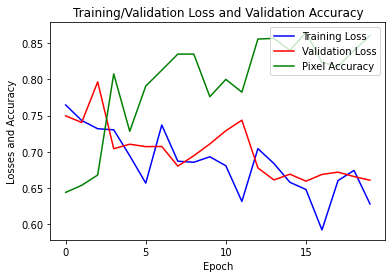

epoch 20, iter 0, loss: 0.5988764762878418
epoch 20, iter 10, loss: 0.558524489402771
epoch 20, iter 20, loss: 0.6756407022476196
epoch 20, iter 30, loss: 0.5967047810554504
epoch 20, iter 40, loss: 0.6155718564987183
epoch 20, iter 50, loss: 0.6501640677452087
epoch 20, iter 60, loss: 0.6342465877532959
epoch 20, iter 70, loss: 0.6296036243438721
epoch 20, iter 80, loss: 0.6919276714324951
epoch 20, iter 90, loss: 0.6168920993804932
epoch 20, iter 100, loss: 0.6584244966506958
Finished epoch 20, time elapsed: 99.32555532455444
Loss at epoch 20: 0.6543747186660767
IoU at epoch 20: 0.4865334964537563
Pixel acc at epoch 20: 0.8582132569831303


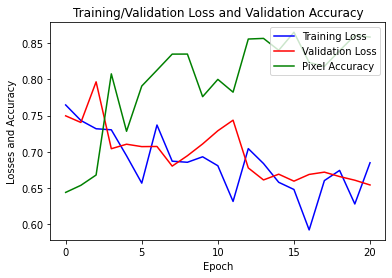

epoch 21, iter 0, loss: 0.6483492851257324
epoch 21, iter 10, loss: 0.6231454610824585
epoch 21, iter 20, loss: 0.6622307300567627
epoch 21, iter 30, loss: 0.6711945533752441
epoch 21, iter 40, loss: 0.6447697281837463
epoch 21, iter 50, loss: 0.6817046999931335
epoch 21, iter 60, loss: 0.6204706430435181
epoch 21, iter 70, loss: 0.6226428747177124
epoch 21, iter 80, loss: 0.6312637329101562
epoch 21, iter 90, loss: 0.6254703998565674
epoch 21, iter 100, loss: 0.6371668577194214
Finished epoch 21, time elapsed: 99.3710150718689
Loss at epoch 21: 0.6658168435096741
IoU at epoch 21: 0.44770097805245496
Pixel acc at epoch 21: 0.8737675894444596
No improvements for 1 rounds.


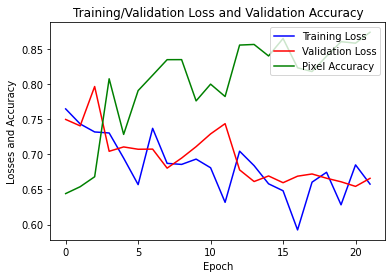

epoch 22, iter 0, loss: 0.6604400873184204
epoch 22, iter 10, loss: 0.5769057273864746
epoch 22, iter 20, loss: 0.5962369441986084
epoch 22, iter 30, loss: 0.636609673500061
epoch 22, iter 40, loss: 0.6008321046829224
epoch 22, iter 50, loss: 0.7397278547286987
epoch 22, iter 60, loss: 0.6784562468528748
epoch 22, iter 70, loss: 0.6632680892944336
epoch 22, iter 80, loss: 0.6429286003112793
epoch 22, iter 90, loss: 0.6123446226119995
epoch 22, iter 100, loss: 0.6489061117172241
Finished epoch 22, time elapsed: 99.3513731956482
Loss at epoch 22: 0.6497449278831482
IoU at epoch 22: 0.49192252144528675
Pixel acc at epoch 22: 0.868555988373979


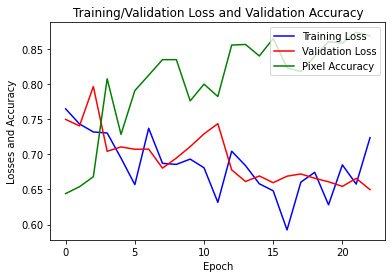

epoch 23, iter 0, loss: 0.6469114422798157
epoch 23, iter 10, loss: 0.6143733859062195
epoch 23, iter 20, loss: 0.6414870023727417
epoch 23, iter 30, loss: 0.6456701755523682
epoch 23, iter 40, loss: 0.5896062850952148
epoch 23, iter 50, loss: 0.6452893614768982
epoch 23, iter 60, loss: 0.6276761889457703
epoch 23, iter 70, loss: 0.6285082101821899
epoch 23, iter 80, loss: 0.5931973457336426
epoch 23, iter 90, loss: 0.5772497653961182
epoch 23, iter 100, loss: 0.7217022180557251
Finished epoch 23, time elapsed: 99.4095778465271
Loss at epoch 23: 0.6498441696166992
IoU at epoch 23: 0.4930926268064494
Pixel acc at epoch 23: 0.8770137607314409


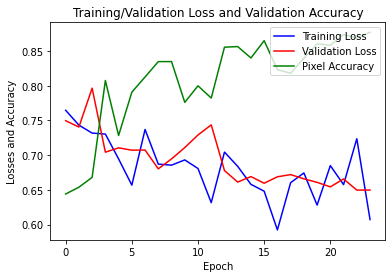

epoch 24, iter 0, loss: 0.6683260202407837
epoch 24, iter 10, loss: 0.6627068519592285
epoch 24, iter 20, loss: 0.5947902798652649
epoch 24, iter 30, loss: 0.579459547996521
epoch 24, iter 40, loss: 0.6089226007461548
epoch 24, iter 50, loss: 0.6476746201515198
epoch 24, iter 60, loss: 0.5968914031982422
epoch 24, iter 70, loss: 0.6396609544754028
epoch 24, iter 80, loss: 0.652240514755249
epoch 24, iter 90, loss: 0.6548581123352051
epoch 24, iter 100, loss: 0.6330502033233643
Finished epoch 24, time elapsed: 99.34270071983337
Loss at epoch 24: 0.660050094127655
IoU at epoch 24: 0.47112007005912204
Pixel acc at epoch 24: 0.8448364993513208
No improvements for 1 rounds.


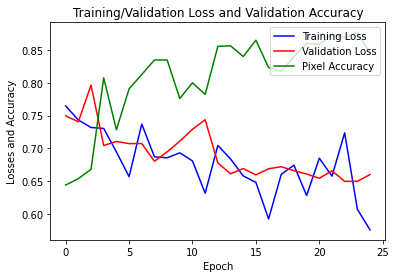

epoch 25, iter 0, loss: 0.5654277801513672
epoch 25, iter 10, loss: 0.6376107931137085
epoch 25, iter 20, loss: 0.6272563338279724
epoch 25, iter 30, loss: 0.5628594160079956
epoch 25, iter 40, loss: 0.6485030651092529
epoch 25, iter 50, loss: 0.6037409901618958
epoch 25, iter 60, loss: 0.6436887979507446
epoch 25, iter 70, loss: 0.663413405418396
epoch 25, iter 80, loss: 0.6461359262466431
epoch 25, iter 90, loss: 0.5898152589797974
epoch 25, iter 100, loss: 0.5656009912490845
Finished epoch 25, time elapsed: 99.41009521484375
Loss at epoch 25: 0.6521148681640625
IoU at epoch 25: 0.4916410652485896
Pixel acc at epoch 25: 0.8685689158423127
No improvements for 2 rounds.


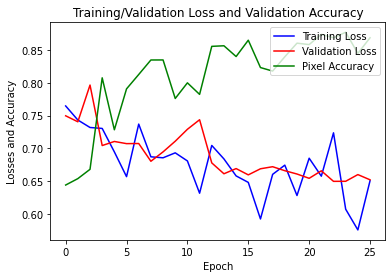

epoch 26, iter 0, loss: 0.625045895576477
epoch 26, iter 10, loss: 0.6011608242988586
epoch 26, iter 20, loss: 0.6243464946746826
epoch 26, iter 30, loss: 0.6222165822982788
epoch 26, iter 40, loss: 0.5968337059020996
epoch 26, iter 50, loss: 0.598110020160675
epoch 26, iter 60, loss: 0.6096938848495483
epoch 26, iter 70, loss: 0.6111129522323608
epoch 26, iter 80, loss: 0.6537787914276123
epoch 26, iter 90, loss: 0.5935060381889343
epoch 26, iter 100, loss: 0.6225892305374146
Finished epoch 26, time elapsed: 99.28083634376526
Loss at epoch 26: 0.6643604636192322
IoU at epoch 26: 0.47004171184052584
Pixel acc at epoch 26: 0.8532290285653694
No improvements for 3 rounds.


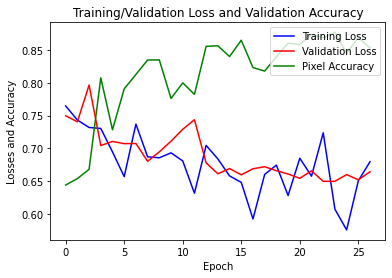

epoch 27, iter 0, loss: 0.5497348308563232
epoch 27, iter 10, loss: 0.5984276533126831
epoch 27, iter 20, loss: 0.6211564540863037
epoch 27, iter 30, loss: 0.6523681879043579
epoch 27, iter 40, loss: 0.592003345489502
epoch 27, iter 50, loss: 0.6224689483642578
epoch 27, iter 60, loss: 0.6348447799682617
epoch 27, iter 70, loss: 0.6294116973876953
epoch 27, iter 80, loss: 0.6114908456802368
epoch 27, iter 90, loss: 0.6624007821083069
epoch 27, iter 100, loss: 0.6377849578857422
Finished epoch 27, time elapsed: 99.10618376731873
Loss at epoch 27: 0.6463200449943542
IoU at epoch 27: 0.48967610481083257
Pixel acc at epoch 27: 0.8834835322670863
No improvements for 4 rounds.


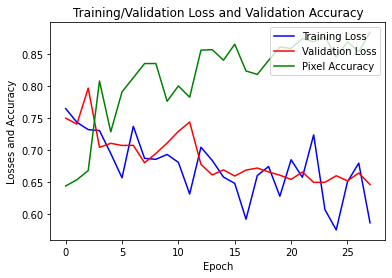

epoch 28, iter 0, loss: 0.5837453007698059
epoch 28, iter 10, loss: 0.6132071018218994
epoch 28, iter 20, loss: 0.6498978137969971
epoch 28, iter 30, loss: 0.6606244444847107
epoch 28, iter 40, loss: 0.587569534778595
epoch 28, iter 50, loss: 0.6408118605613708
epoch 28, iter 60, loss: 0.6744586229324341
epoch 28, iter 70, loss: 0.6700574159622192
epoch 28, iter 80, loss: 0.6430761814117432
epoch 28, iter 90, loss: 0.6711215376853943
epoch 28, iter 100, loss: 0.5811665058135986
Finished epoch 28, time elapsed: 99.10529589653015
Loss at epoch 28: 0.6518774628639221
IoU at epoch 28: 0.5007395367729259
Pixel acc at epoch 28: 0.8854802410730753


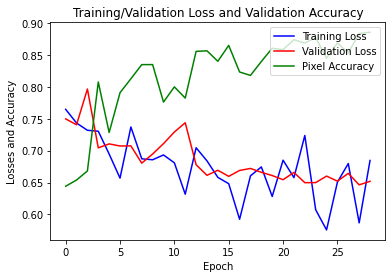

epoch 29, iter 0, loss: 0.6575816869735718
epoch 29, iter 10, loss: 0.630455732345581
epoch 29, iter 20, loss: 0.6184772253036499
epoch 29, iter 30, loss: 0.5688315629959106
epoch 29, iter 40, loss: 0.627707839012146
epoch 29, iter 50, loss: 0.5942182540893555
epoch 29, iter 60, loss: 0.6000995635986328
epoch 29, iter 70, loss: 0.626814603805542
epoch 29, iter 80, loss: 0.6133601069450378
epoch 29, iter 90, loss: 0.5851258039474487
epoch 29, iter 100, loss: 0.5366385579109192
Finished epoch 29, time elapsed: 99.11151361465454
Loss at epoch 29: 0.6471655964851379
IoU at epoch 29: 0.4920839485730617
Pixel acc at epoch 29: 0.8622309579136546
No improvements for 1 rounds.


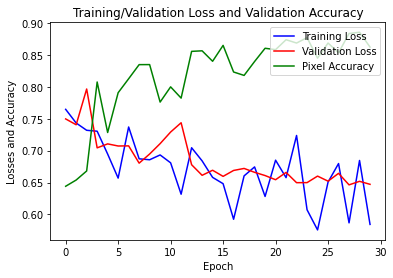

epoch 30, iter 0, loss: 0.5988898277282715
epoch 30, iter 10, loss: 0.6019078493118286
epoch 30, iter 20, loss: 0.6114130020141602
epoch 30, iter 30, loss: 0.6376305818557739
epoch 30, iter 40, loss: 0.6236921548843384
epoch 30, iter 50, loss: 0.591048538684845
epoch 30, iter 60, loss: 0.637776255607605
epoch 30, iter 70, loss: 0.65045166015625
epoch 30, iter 80, loss: 0.6105091571807861
epoch 30, iter 90, loss: 0.6119248867034912
epoch 30, iter 100, loss: 0.6780454516410828
Finished epoch 30, time elapsed: 99.02969312667847
Loss at epoch 30: 0.6477436423301697
IoU at epoch 30: 0.49998071342032474
Pixel acc at epoch 30: 0.8430841255763889
No improvements for 2 rounds.


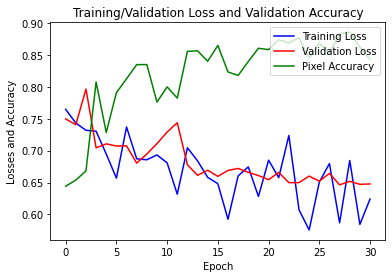

epoch 31, iter 0, loss: 0.5647478103637695
epoch 31, iter 10, loss: 0.6151951551437378
epoch 31, iter 20, loss: 0.5963008403778076
epoch 31, iter 30, loss: 0.6523251533508301
epoch 31, iter 40, loss: 0.6370113492012024
epoch 31, iter 50, loss: 0.5836471319198608
epoch 31, iter 60, loss: 0.5871707201004028
epoch 31, iter 70, loss: 0.6091268062591553
epoch 31, iter 80, loss: 0.6087371110916138
epoch 31, iter 90, loss: 0.6486976146697998
epoch 31, iter 100, loss: 0.5836817026138306
Finished epoch 31, time elapsed: 99.14611840248108
Loss at epoch 31: 0.6489343643188477
IoU at epoch 31: 0.4894404990739651
Pixel acc at epoch 31: 0.833322834792716
No improvements for 3 rounds.


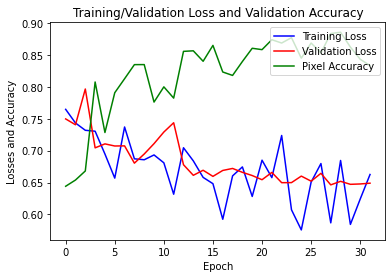

epoch 32, iter 0, loss: 0.6302987933158875
epoch 32, iter 10, loss: 0.6009739637374878
epoch 32, iter 20, loss: 0.6538331508636475
epoch 32, iter 30, loss: 0.5722196102142334
epoch 32, iter 40, loss: 0.6144327521324158
epoch 32, iter 50, loss: 0.610824465751648
epoch 32, iter 60, loss: 0.6317126750946045
epoch 32, iter 70, loss: 0.6527959704399109
epoch 32, iter 80, loss: 0.5974229574203491
epoch 32, iter 90, loss: 0.5974993109703064
epoch 32, iter 100, loss: 0.6162427067756653
Finished epoch 32, time elapsed: 99.10354089736938
Loss at epoch 32: 0.6468808650970459
IoU at epoch 32: 0.5001219167144263
Pixel acc at epoch 32: 0.8719318395529085
No improvements for 4 rounds.


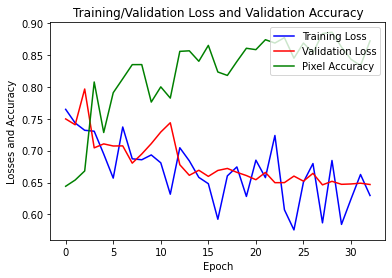

epoch 33, iter 0, loss: 0.5725939273834229
epoch 33, iter 10, loss: 0.5796958208084106
epoch 33, iter 20, loss: 0.5933504104614258
epoch 33, iter 30, loss: 0.584309458732605
epoch 33, iter 40, loss: 0.6263677477836609
epoch 33, iter 50, loss: 0.6304519176483154
epoch 33, iter 60, loss: 0.5790111422538757
epoch 33, iter 70, loss: 0.5831102132797241
epoch 33, iter 80, loss: 0.6038094758987427
epoch 33, iter 90, loss: 0.592339038848877
epoch 33, iter 100, loss: 0.643625020980835
Finished epoch 33, time elapsed: 99.2347629070282
Loss at epoch 33: 0.6559228301048279
IoU at epoch 33: 0.45731828673046293
Pixel acc at epoch 33: 0.8603653669616917
No improvements for 5 rounds.


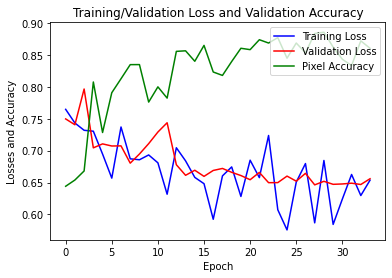

epoch 34, iter 0, loss: 0.5800802707672119
epoch 34, iter 10, loss: 0.6287128925323486
epoch 34, iter 20, loss: 0.5874631404876709
epoch 34, iter 30, loss: 0.6327974200248718
epoch 34, iter 40, loss: 0.579413115978241
epoch 34, iter 50, loss: 0.6587468981742859
epoch 34, iter 60, loss: 0.6192193031311035
epoch 34, iter 70, loss: 0.64902263879776
epoch 34, iter 80, loss: 0.6140944957733154
epoch 34, iter 90, loss: 0.6485923528671265
epoch 34, iter 100, loss: 0.5884261131286621
Finished epoch 34, time elapsed: 99.03091049194336
Loss at epoch 34: 0.64279705286026
IoU at epoch 34: 0.49666958394188343
Pixel acc at epoch 34: 0.8782368714188501
No improvements for 6 rounds.


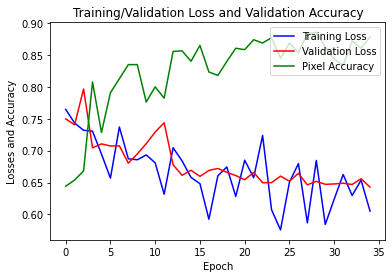

epoch 35, iter 0, loss: 0.5452473163604736
epoch 35, iter 10, loss: 0.5768393278121948
epoch 35, iter 20, loss: 0.5896282196044922
epoch 35, iter 30, loss: 0.6217853426933289
epoch 35, iter 40, loss: 0.6275436878204346
epoch 35, iter 50, loss: 0.5900585651397705
epoch 35, iter 60, loss: 0.5947729349136353
epoch 35, iter 70, loss: 0.6450936794281006
epoch 35, iter 80, loss: 0.6274299621582031
epoch 35, iter 90, loss: 0.6259925961494446
epoch 35, iter 100, loss: 0.5741759538650513
Finished epoch 35, time elapsed: 99.09499049186707
Loss at epoch 35: 0.6451370716094971
IoU at epoch 35: 0.5053555090094363
Pixel acc at epoch 35: 0.84350727063893


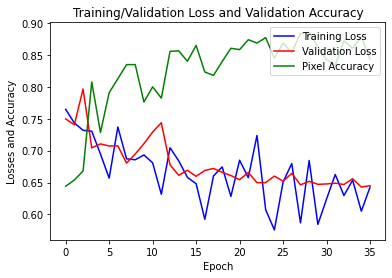

epoch 36, iter 0, loss: 0.6076699495315552
epoch 36, iter 10, loss: 0.71295166015625
epoch 36, iter 20, loss: 0.606207013130188
epoch 36, iter 30, loss: 0.6248905062675476
epoch 36, iter 40, loss: 0.6578527688980103
epoch 36, iter 50, loss: 0.6137363910675049
epoch 36, iter 60, loss: 0.6297614574432373
epoch 36, iter 70, loss: 0.6314939260482788
epoch 36, iter 80, loss: 0.5826452970504761
epoch 36, iter 90, loss: 0.6347455978393555
epoch 36, iter 100, loss: 0.5899747610092163
Finished epoch 36, time elapsed: 99.01564168930054
Loss at epoch 36: 0.6441569924354553
IoU at epoch 36: 0.5070322980811474
Pixel acc at epoch 36: 0.8760188628898605


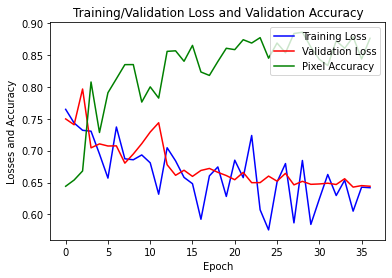

epoch 37, iter 0, loss: 0.5654273629188538
epoch 37, iter 10, loss: 0.6567572355270386
epoch 37, iter 20, loss: 0.5770066976547241
epoch 37, iter 30, loss: 0.6702487468719482
epoch 37, iter 40, loss: 0.6082103848457336
epoch 37, iter 50, loss: 0.6315404176712036
epoch 37, iter 60, loss: 0.6238905191421509
epoch 37, iter 70, loss: 0.5867583751678467
epoch 37, iter 80, loss: 0.6208171248435974
epoch 37, iter 90, loss: 0.632135808467865
epoch 37, iter 100, loss: 0.6187342405319214
Finished epoch 37, time elapsed: 99.05362224578857
Loss at epoch 37: 0.6305859088897705
IoU at epoch 37: 0.5465182407928331
Pixel acc at epoch 37: 0.9068787006497173


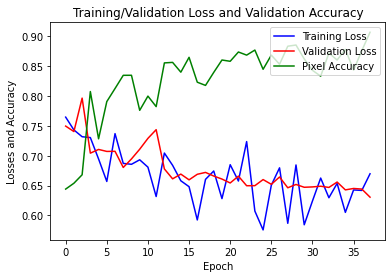

epoch 38, iter 0, loss: 0.5858181715011597
epoch 38, iter 10, loss: 0.6342970132827759
epoch 38, iter 20, loss: 0.5608757734298706
epoch 38, iter 30, loss: 0.5837354063987732
epoch 38, iter 40, loss: 0.6082137227058411
epoch 38, iter 50, loss: 0.5896494388580322
epoch 38, iter 60, loss: 0.6698566675186157
epoch 38, iter 70, loss: 0.6357386708259583
epoch 38, iter 80, loss: 0.6658034324645996
epoch 38, iter 90, loss: 0.5597267150878906
epoch 38, iter 100, loss: 0.6145179271697998
Finished epoch 38, time elapsed: 99.39853596687317
Loss at epoch 38: 0.6432473659515381
IoU at epoch 38: 0.5020499866902718
Pixel acc at epoch 38: 0.8927844073957096
No improvements for 1 rounds.


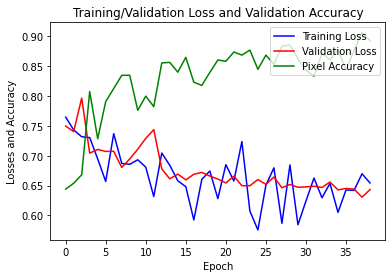

epoch 39, iter 0, loss: 0.6212636828422546
epoch 39, iter 10, loss: 0.6219019889831543
epoch 39, iter 20, loss: 0.6162029504776001
epoch 39, iter 30, loss: 0.6307518482208252
epoch 39, iter 40, loss: 0.5846637487411499
epoch 39, iter 50, loss: 0.6318284273147583
epoch 39, iter 60, loss: 0.6431362628936768
epoch 39, iter 70, loss: 0.6399146318435669
epoch 39, iter 80, loss: 0.598712682723999
epoch 39, iter 90, loss: 0.5564172267913818
epoch 39, iter 100, loss: 0.6434272527694702
Finished epoch 39, time elapsed: 99.04387545585632
Loss at epoch 39: 0.6421717405319214
IoU at epoch 39: 0.5116251841174105
Pixel acc at epoch 39: 0.8758256464642836
No improvements for 2 rounds.


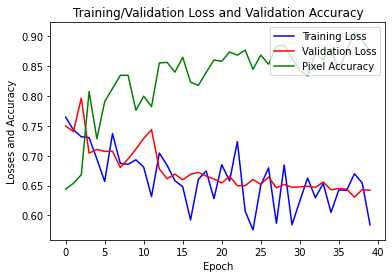

epoch 40, iter 0, loss: 0.6371612548828125
epoch 40, iter 10, loss: 0.648461103439331
epoch 40, iter 20, loss: 0.5492194890975952
epoch 40, iter 30, loss: 0.5436640381813049
epoch 40, iter 40, loss: 0.6064023375511169
epoch 40, iter 50, loss: 0.6252924203872681
epoch 40, iter 60, loss: 0.5817766189575195
epoch 40, iter 70, loss: 0.6768822073936462
epoch 40, iter 80, loss: 0.635664165019989
epoch 40, iter 90, loss: 0.6383796334266663
epoch 40, iter 100, loss: 0.6372177600860596
Finished epoch 40, time elapsed: 99.09408020973206
Loss at epoch 40: 0.641381561756134
IoU at epoch 40: 0.5001258705518915
Pixel acc at epoch 40: 0.8776234538313236
No improvements for 3 rounds.


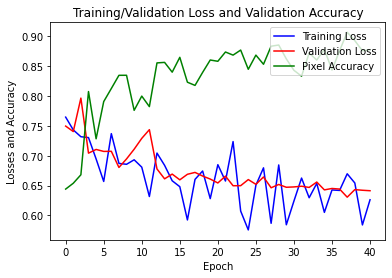

epoch 41, iter 0, loss: 0.5666680932044983
epoch 41, iter 10, loss: 0.7106592059135437
epoch 41, iter 20, loss: 0.5832269191741943
epoch 41, iter 30, loss: 0.6555618047714233
epoch 41, iter 40, loss: 0.6329518556594849
epoch 41, iter 50, loss: 0.5898628234863281
epoch 41, iter 60, loss: 0.6730875968933105
epoch 41, iter 70, loss: 0.5892674922943115
epoch 41, iter 80, loss: 0.636398434638977
epoch 41, iter 90, loss: 0.583882212638855
epoch 41, iter 100, loss: 0.5771805644035339
Finished epoch 41, time elapsed: 99.24671864509583
Loss at epoch 41: 0.6309766173362732
IoU at epoch 41: 0.5360926109301188
Pixel acc at epoch 41: 0.8933945490106814
No improvements for 4 rounds.


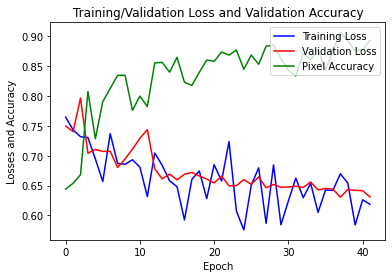

epoch 42, iter 0, loss: 0.6079492568969727
epoch 42, iter 10, loss: 0.6120908856391907
epoch 42, iter 20, loss: 0.5610297918319702
epoch 42, iter 30, loss: 0.6319406032562256
epoch 42, iter 40, loss: 0.590421199798584
epoch 42, iter 50, loss: 0.6358052492141724
epoch 42, iter 60, loss: 0.5581849813461304
epoch 42, iter 70, loss: 0.6383602619171143
epoch 42, iter 80, loss: 0.5785702466964722
epoch 42, iter 90, loss: 0.6598868370056152
epoch 42, iter 100, loss: 0.5908883213996887
Finished epoch 42, time elapsed: 99.17233633995056
Loss at epoch 42: 0.6396338939666748
IoU at epoch 42: 0.5262020019268302
Pixel acc at epoch 42: 0.8942607063233535
No improvements for 5 rounds.


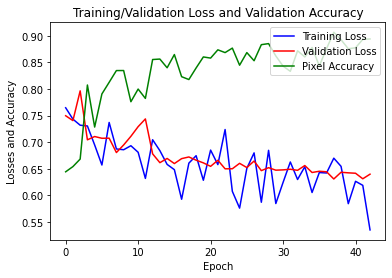

epoch 43, iter 0, loss: 0.6258681416511536
epoch 43, iter 10, loss: 0.6486932039260864
epoch 43, iter 20, loss: 0.6160184144973755
epoch 43, iter 30, loss: 0.612368106842041
epoch 43, iter 40, loss: 0.5654141902923584
epoch 43, iter 50, loss: 0.6155071258544922
epoch 43, iter 60, loss: 0.5936193466186523
epoch 43, iter 70, loss: 0.618446946144104
epoch 43, iter 80, loss: 0.5635292530059814
epoch 43, iter 90, loss: 0.5944190621376038
epoch 43, iter 100, loss: 0.61565101146698
Finished epoch 43, time elapsed: 99.11032342910767
Loss at epoch 43: 0.6350967884063721
IoU at epoch 43: 0.5190139586573062
Pixel acc at epoch 43: 0.8739042984249834
No improvements for 6 rounds.


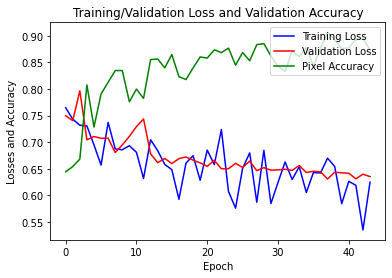

epoch 44, iter 0, loss: 0.6526011824607849
epoch 44, iter 10, loss: 0.5852246284484863
epoch 44, iter 20, loss: 0.6151489019393921
epoch 44, iter 30, loss: 0.5166062116622925
epoch 44, iter 40, loss: 0.6358043551445007
epoch 44, iter 50, loss: 0.6559805870056152
epoch 44, iter 60, loss: 0.6031948328018188
epoch 44, iter 70, loss: 0.5825139880180359
epoch 44, iter 80, loss: 0.6496769785881042
epoch 44, iter 90, loss: 0.5601202249526978
epoch 44, iter 100, loss: 0.5961475372314453
Finished epoch 44, time elapsed: 99.17215991020203
Loss at epoch 44: 0.6436415314674377
IoU at epoch 44: 0.493849652057372
Pixel acc at epoch 44: 0.8720101040124819
No improvements for 7 rounds.


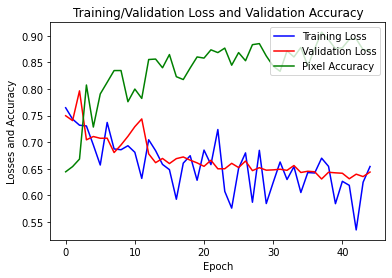

epoch 45, iter 0, loss: 0.6004016399383545
epoch 45, iter 10, loss: 0.6170393228530884
epoch 45, iter 20, loss: 0.6366767883300781
epoch 45, iter 30, loss: 0.5602977275848389
epoch 45, iter 40, loss: 0.6058450937271118
epoch 45, iter 50, loss: 0.5505775809288025
epoch 45, iter 60, loss: 0.5780557990074158
epoch 45, iter 70, loss: 0.6507570147514343
epoch 45, iter 80, loss: 0.5825862288475037
epoch 45, iter 90, loss: 0.6031631231307983
epoch 45, iter 100, loss: 0.5521522164344788
Finished epoch 45, time elapsed: 99.43500447273254
Loss at epoch 45: 0.6277657151222229
IoU at epoch 45: 0.532861168499192
Pixel acc at epoch 45: 0.8891387762708166
No improvements for 8 rounds.


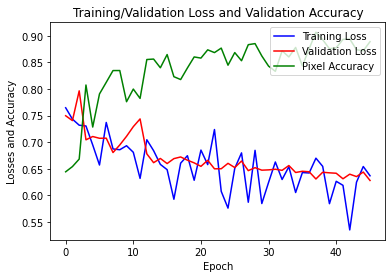

epoch 46, iter 0, loss: 0.5852904915809631
epoch 46, iter 10, loss: 0.5758258700370789
epoch 46, iter 20, loss: 0.6472340226173401
epoch 46, iter 30, loss: 0.590896487236023
epoch 46, iter 40, loss: 0.607699990272522
epoch 46, iter 50, loss: 0.5666922330856323
epoch 46, iter 60, loss: 0.6271246671676636
epoch 46, iter 70, loss: 0.5748007893562317
epoch 46, iter 80, loss: 0.5614891648292542
epoch 46, iter 90, loss: 0.6235666275024414
epoch 46, iter 100, loss: 0.624689519405365
Finished epoch 46, time elapsed: 99.23402714729309
Loss at epoch 46: 0.6408885717391968
IoU at epoch 46: 0.5274577557266077
Pixel acc at epoch 46: 0.8872125168393544
No improvements for 9 rounds.


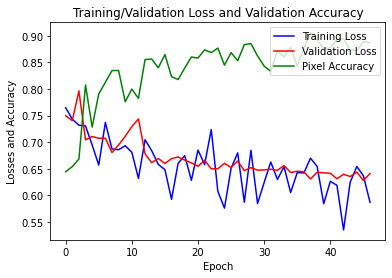

epoch 47, iter 0, loss: 0.6021714210510254
epoch 47, iter 10, loss: 0.5977156162261963
epoch 47, iter 20, loss: 0.677729070186615
epoch 47, iter 30, loss: 0.6408140659332275
epoch 47, iter 40, loss: 0.6151964068412781
epoch 47, iter 50, loss: 0.6254915595054626
epoch 47, iter 60, loss: 0.6158812046051025
epoch 47, iter 70, loss: 0.6019315719604492
epoch 47, iter 80, loss: 0.669070839881897
epoch 47, iter 90, loss: 0.6116132736206055
epoch 47, iter 100, loss: 0.5988731384277344
Finished epoch 47, time elapsed: 99.10855078697205
Loss at epoch 47: 0.6539040207862854
IoU at epoch 47: 0.491099531015894
Pixel acc at epoch 47: 0.7903586733813925
No improvements for 10 rounds.


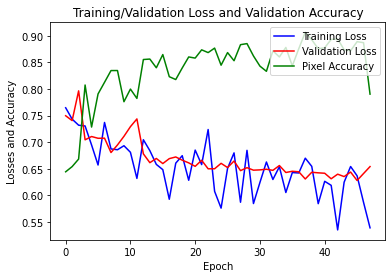

epoch 48, iter 0, loss: 0.6283490657806396
epoch 48, iter 10, loss: 0.6196386814117432
epoch 48, iter 20, loss: 0.5815988779067993
epoch 48, iter 30, loss: 0.6449434161186218
epoch 48, iter 40, loss: 0.5937095880508423
epoch 48, iter 50, loss: 0.6305265426635742
epoch 48, iter 60, loss: 0.6198199391365051
epoch 48, iter 70, loss: 0.5621331930160522
epoch 48, iter 80, loss: 0.5957465171813965
epoch 48, iter 90, loss: 0.6020655035972595
epoch 48, iter 100, loss: 0.7147831320762634
Finished epoch 48, time elapsed: 99.01240992546082
Loss at epoch 48: 0.6482707262039185
IoU at epoch 48: 0.4912805916488844
Pixel acc at epoch 48: 0.8577445131159445
No improvements for 11 rounds.


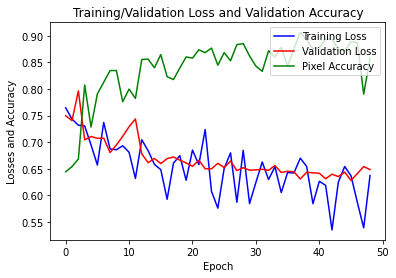

epoch 49, iter 0, loss: 0.550197958946228
epoch 49, iter 10, loss: 0.6303399205207825
epoch 49, iter 20, loss: 0.5728945732116699
epoch 49, iter 30, loss: 0.6141973733901978
epoch 49, iter 40, loss: 0.6026379466056824
epoch 49, iter 50, loss: 0.5969958901405334
epoch 49, iter 60, loss: 0.5808007121086121
epoch 49, iter 70, loss: 0.6423043012619019
epoch 49, iter 80, loss: 0.6292657852172852
epoch 49, iter 90, loss: 0.6372524499893188
epoch 49, iter 100, loss: 0.6212571263313293
Finished epoch 49, time elapsed: 99.28924942016602
Loss at epoch 49: 0.6503661274909973
IoU at epoch 49: 0.4994285271838517
Pixel acc at epoch 49: 0.8780860291250191
No improvements for 12 rounds.


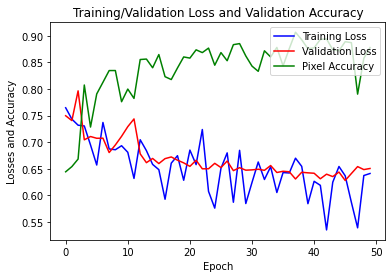

epoch 50, iter 0, loss: 0.5677677392959595
epoch 50, iter 10, loss: 0.5532388687133789
epoch 50, iter 20, loss: 0.6150766611099243
epoch 50, iter 30, loss: 0.7026964426040649
epoch 50, iter 40, loss: 0.6247156858444214
epoch 50, iter 50, loss: 0.6319524049758911
epoch 50, iter 60, loss: 0.6338789463043213
epoch 50, iter 70, loss: 0.6399496793746948
epoch 50, iter 80, loss: 0.6285004615783691
epoch 50, iter 90, loss: 0.6038963794708252
epoch 50, iter 100, loss: 0.6064915657043457
Finished epoch 50, time elapsed: 99.32879996299744
Loss at epoch 50: 0.6344503164291382
IoU at epoch 50: 0.5259304296206243
Pixel acc at epoch 50: 0.8960046677761146
No improvements for 13 rounds.


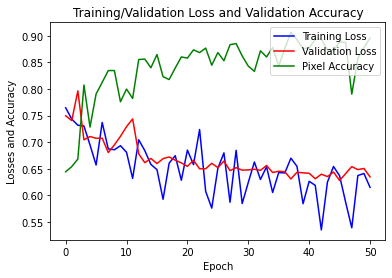

epoch 51, iter 0, loss: 0.5343412160873413
epoch 51, iter 10, loss: 0.5663069486618042
epoch 51, iter 20, loss: 0.6579532623291016
epoch 51, iter 30, loss: 0.6454268097877502
epoch 51, iter 40, loss: 0.5962936282157898
epoch 51, iter 50, loss: 0.5944147109985352
epoch 51, iter 60, loss: 0.6196709871292114
epoch 51, iter 70, loss: 0.6429405212402344
epoch 51, iter 80, loss: 0.5878372192382812
epoch 51, iter 90, loss: 0.566130518913269
epoch 51, iter 100, loss: 0.638721227645874
Finished epoch 51, time elapsed: 99.32184314727783
Loss at epoch 51: 0.627730131149292
IoU at epoch 51: 0.5454702864356984
Pixel acc at epoch 51: 0.887424933159877
No improvements for 14 rounds.


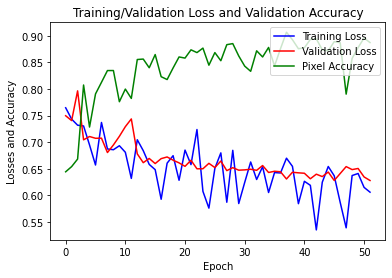

epoch 52, iter 0, loss: 0.511806070804596
epoch 52, iter 10, loss: 0.5962204933166504
epoch 52, iter 20, loss: 0.6144473552703857
epoch 52, iter 30, loss: 0.5764673948287964
epoch 52, iter 40, loss: 0.6193541288375854
epoch 52, iter 50, loss: 0.553084135055542
epoch 52, iter 60, loss: 0.6027522087097168
epoch 52, iter 70, loss: 0.6151807308197021
epoch 52, iter 80, loss: 0.6031930446624756
epoch 52, iter 90, loss: 0.5752485990524292
epoch 52, iter 100, loss: 0.594446063041687
Finished epoch 52, time elapsed: 99.2812430858612
Loss at epoch 52: 0.6383492350578308
IoU at epoch 52: 0.519066092582028
Pixel acc at epoch 52: 0.876328221276512
No improvements for 15 rounds.


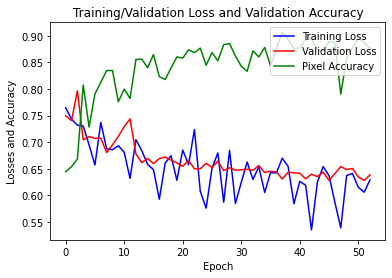

epoch 53, iter 0, loss: 0.6225073933601379
epoch 53, iter 10, loss: 0.6042757034301758
epoch 53, iter 20, loss: 0.5845602750778198
epoch 53, iter 30, loss: 0.5755727291107178
epoch 53, iter 40, loss: 0.5801609754562378
epoch 53, iter 50, loss: 0.580085039138794
epoch 53, iter 60, loss: 0.5657873749732971
epoch 53, iter 70, loss: 0.5647863149642944
epoch 53, iter 80, loss: 0.5916293263435364
epoch 53, iter 90, loss: 0.5208096504211426
epoch 53, iter 100, loss: 0.5560884475708008
Finished epoch 53, time elapsed: 99.23118591308594
Loss at epoch 53: 0.6293426156044006
IoU at epoch 53: 0.5476362284045301
Pixel acc at epoch 53: 0.8860294598902724


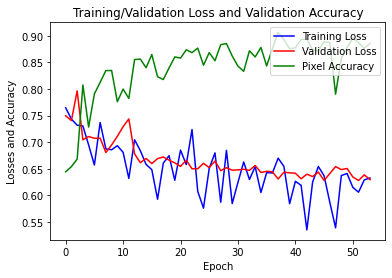

epoch 54, iter 0, loss: 0.5593098402023315
epoch 54, iter 10, loss: 0.6462388634681702
epoch 54, iter 20, loss: 0.5943812131881714
epoch 54, iter 30, loss: 0.5959036946296692
epoch 54, iter 40, loss: 0.5712622404098511
epoch 54, iter 50, loss: 0.6386135816574097
epoch 54, iter 60, loss: 0.5772824883460999
epoch 54, iter 70, loss: 0.5481094121932983
epoch 54, iter 80, loss: 0.5794724225997925
epoch 54, iter 90, loss: 0.5852285027503967
epoch 54, iter 100, loss: 0.6141719818115234
Finished epoch 54, time elapsed: 99.32690167427063
Loss at epoch 54: 0.6401633024215698
IoU at epoch 54: 0.5131269701351995
Pixel acc at epoch 54: 0.8861714043703407
No improvements for 1 rounds.


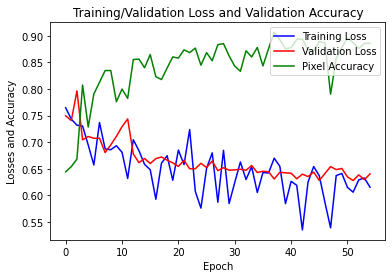

epoch 55, iter 0, loss: 0.6510447263717651
epoch 55, iter 10, loss: 0.5832846760749817
epoch 55, iter 20, loss: 0.5976744294166565
epoch 55, iter 30, loss: 0.6267536878585815
epoch 55, iter 40, loss: 0.5578152537345886
epoch 55, iter 50, loss: 0.6652988195419312
epoch 55, iter 60, loss: 0.6087660193443298
epoch 55, iter 70, loss: 0.5794176459312439
epoch 55, iter 80, loss: 0.5960900187492371
epoch 55, iter 90, loss: 0.577492892742157
epoch 55, iter 100, loss: 0.5927752256393433
Finished epoch 55, time elapsed: 99.38504838943481
Loss at epoch 55: 0.6277587413787842
IoU at epoch 55: 0.5288439821966401
Pixel acc at epoch 55: 0.8978461574981668
No improvements for 2 rounds.


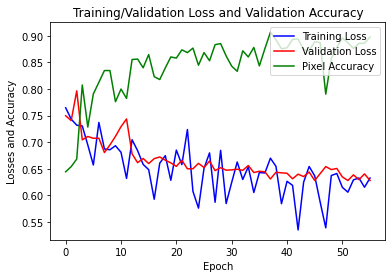

epoch 56, iter 0, loss: 0.5995458364486694
epoch 56, iter 10, loss: 0.5920417904853821
epoch 56, iter 20, loss: 0.618229866027832
epoch 56, iter 30, loss: 0.6551154851913452
epoch 56, iter 40, loss: 0.6288992166519165
epoch 56, iter 50, loss: 0.5869656205177307
epoch 56, iter 60, loss: 0.7562453746795654
epoch 56, iter 70, loss: 0.5868842601776123
epoch 56, iter 80, loss: 0.5950757265090942
epoch 56, iter 90, loss: 0.580553412437439
epoch 56, iter 100, loss: 0.5224428176879883
Finished epoch 56, time elapsed: 99.65879583358765
Loss at epoch 56: 0.626785933971405
IoU at epoch 56: 0.5618501470113103
Pixel acc at epoch 56: 0.8860730333621087


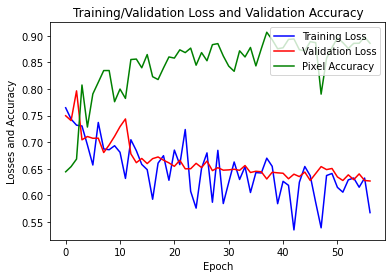

epoch 57, iter 0, loss: 0.535345733165741
epoch 57, iter 10, loss: 0.5992746353149414
epoch 57, iter 20, loss: 0.63869309425354
epoch 57, iter 30, loss: 0.641977846622467
epoch 57, iter 40, loss: 0.5224798917770386
epoch 57, iter 50, loss: 0.5459014773368835
epoch 57, iter 60, loss: 0.5458633303642273
epoch 57, iter 70, loss: 0.6128787398338318
epoch 57, iter 80, loss: 0.581418514251709
epoch 57, iter 90, loss: 0.619383692741394
epoch 57, iter 100, loss: 0.5810973644256592
Finished epoch 57, time elapsed: 99.56771731376648
Loss at epoch 57: 0.6367886066436768
IoU at epoch 57: 0.5145396958135117
Pixel acc at epoch 57: 0.8851294986177637
No improvements for 1 rounds.


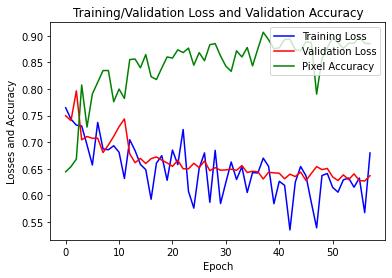

epoch 58, iter 0, loss: 0.6140944957733154
epoch 58, iter 10, loss: 0.5533767342567444
epoch 58, iter 20, loss: 0.5758458971977234
epoch 58, iter 30, loss: 0.6044384241104126
epoch 58, iter 40, loss: 0.6073071956634521
epoch 58, iter 50, loss: 0.6360948085784912
epoch 58, iter 60, loss: 0.564834713935852
epoch 58, iter 70, loss: 0.6365215182304382
epoch 58, iter 80, loss: 0.6130528450012207
epoch 58, iter 90, loss: 0.6888018846511841
epoch 58, iter 100, loss: 0.6364271640777588
Finished epoch 58, time elapsed: 99.54809260368347
Loss at epoch 58: 0.6281668543815613
IoU at epoch 58: 0.5425840309689816
Pixel acc at epoch 58: 0.8834029640436979
No improvements for 2 rounds.


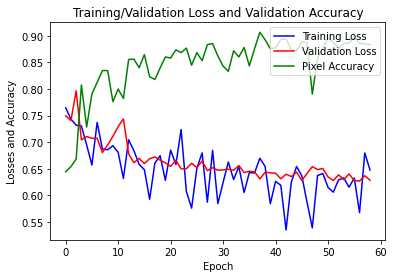

epoch 59, iter 0, loss: 0.6350721120834351
epoch 59, iter 10, loss: 0.5701664686203003
epoch 59, iter 20, loss: 0.5902430415153503
epoch 59, iter 30, loss: 0.6039709448814392
epoch 59, iter 40, loss: 0.5602268576622009
epoch 59, iter 50, loss: 0.6071240901947021
epoch 59, iter 60, loss: 0.6127578020095825
epoch 59, iter 70, loss: 0.5858322978019714
epoch 59, iter 80, loss: 0.6212007999420166
epoch 59, iter 90, loss: 0.6499693989753723
epoch 59, iter 100, loss: 0.6289882659912109
Finished epoch 59, time elapsed: 99.34005832672119
Loss at epoch 59: 0.6347700953483582
IoU at epoch 59: 0.5293144040899861
Pixel acc at epoch 59: 0.8996638741398979
No improvements for 3 rounds.


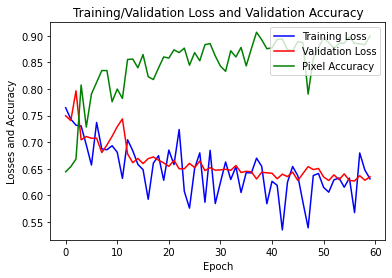

epoch 60, iter 0, loss: 0.6507405638694763
epoch 60, iter 10, loss: 0.5675054788589478
epoch 60, iter 20, loss: 0.5584819316864014
epoch 60, iter 30, loss: 0.553459882736206
epoch 60, iter 40, loss: 0.5592467784881592
epoch 60, iter 50, loss: 0.5266509056091309
epoch 60, iter 60, loss: 0.6544125080108643
epoch 60, iter 70, loss: 0.5837693214416504
epoch 60, iter 80, loss: 0.6119255423545837
epoch 60, iter 90, loss: 0.6331268548965454
epoch 60, iter 100, loss: 0.6271774172782898
Finished epoch 60, time elapsed: 99.25795888900757
Loss at epoch 60: 0.6291621923446655
IoU at epoch 60: 0.5348795210352282
Pixel acc at epoch 60: 0.8744811869087891
No improvements for 4 rounds.


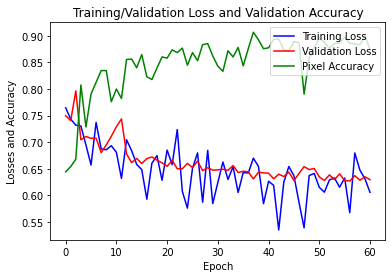

epoch 61, iter 0, loss: 0.5839161276817322
epoch 61, iter 10, loss: 0.552203893661499
epoch 61, iter 20, loss: 0.6097965240478516
epoch 61, iter 30, loss: 0.570149302482605
epoch 61, iter 40, loss: 0.6251558065414429
epoch 61, iter 50, loss: 0.4801030158996582
epoch 61, iter 60, loss: 0.59757399559021
epoch 61, iter 70, loss: 0.5690786242485046
epoch 61, iter 80, loss: 0.5579135417938232
epoch 61, iter 90, loss: 0.6264051198959351
epoch 61, iter 100, loss: 0.5598391890525818
Finished epoch 61, time elapsed: 99.55025243759155
Loss at epoch 61: 0.6399036645889282
IoU at epoch 61: 0.5130210148234384
Pixel acc at epoch 61: 0.8550724752246678
No improvements for 5 rounds.


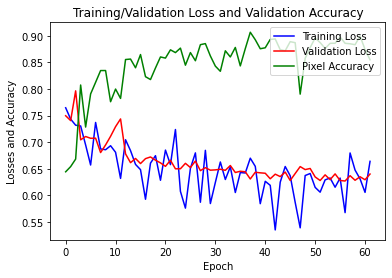

epoch 62, iter 0, loss: 0.6179089546203613
epoch 62, iter 10, loss: 0.5210086703300476
epoch 62, iter 20, loss: 0.6405067443847656
epoch 62, iter 30, loss: 0.5695815086364746
epoch 62, iter 40, loss: 0.6156067848205566
epoch 62, iter 50, loss: 0.5714235305786133
epoch 62, iter 60, loss: 0.5267957448959351
epoch 62, iter 70, loss: 0.5196821093559265
epoch 62, iter 80, loss: 0.5689120888710022
epoch 62, iter 90, loss: 0.5631670355796814
epoch 62, iter 100, loss: 0.7065234184265137
Finished epoch 62, time elapsed: 99.62394189834595
Loss at epoch 62: 0.6316424608230591
IoU at epoch 62: 0.5384765013035175
Pixel acc at epoch 62: 0.8820569483728167
No improvements for 6 rounds.


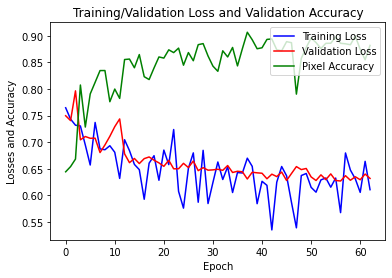

epoch 63, iter 0, loss: 0.5484163761138916
epoch 63, iter 10, loss: 0.5962439775466919
epoch 63, iter 20, loss: 0.6249475479125977
epoch 63, iter 30, loss: 0.5756492614746094
epoch 63, iter 40, loss: 0.6499962210655212
epoch 63, iter 50, loss: 0.5612950325012207
epoch 63, iter 60, loss: 0.6012762784957886
epoch 63, iter 70, loss: 0.615207850933075
epoch 63, iter 80, loss: 0.6001154184341431
epoch 63, iter 90, loss: 0.5895413160324097
epoch 63, iter 100, loss: 0.5121347904205322
Finished epoch 63, time elapsed: 99.45491480827332
Loss at epoch 63: 0.6294693350791931
IoU at epoch 63: 0.5574837719893645
Pixel acc at epoch 63: 0.9012984751090409
No improvements for 7 rounds.


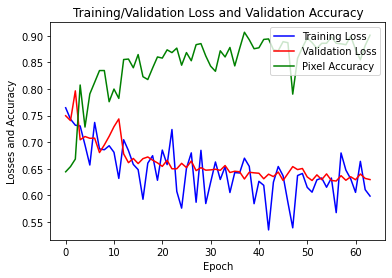

epoch 64, iter 0, loss: 0.5149762630462646
epoch 64, iter 10, loss: 0.6289412975311279
epoch 64, iter 20, loss: 0.5378674268722534
epoch 64, iter 30, loss: 0.6001167297363281
epoch 64, iter 40, loss: 0.5639427900314331
epoch 64, iter 50, loss: 0.7414448857307434
epoch 64, iter 60, loss: 0.5630670785903931
epoch 64, iter 70, loss: 0.6132216453552246
epoch 64, iter 80, loss: 0.5980488061904907
epoch 64, iter 90, loss: 0.47926002740859985
epoch 64, iter 100, loss: 0.6205971240997314
Finished epoch 64, time elapsed: 99.20802235603333
Loss at epoch 64: 0.6276062726974487
IoU at epoch 64: 0.5480408619652979
Pixel acc at epoch 64: 0.9064668427015825
No improvements for 8 rounds.


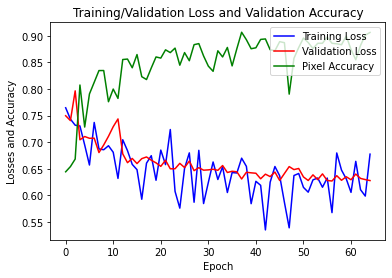

epoch 65, iter 0, loss: 0.586978554725647
epoch 65, iter 10, loss: 0.49844270944595337
epoch 65, iter 20, loss: 0.5801421403884888
epoch 65, iter 30, loss: 0.5540927052497864
epoch 65, iter 40, loss: 0.5490339994430542
epoch 65, iter 50, loss: 0.5395563840866089
epoch 65, iter 60, loss: 0.5609615445137024
epoch 65, iter 70, loss: 0.5359088778495789
epoch 65, iter 80, loss: 0.5183646082878113
epoch 65, iter 90, loss: 0.5309284925460815
epoch 65, iter 100, loss: 0.6213325262069702
Finished epoch 65, time elapsed: 99.14175271987915
Loss at epoch 65: 0.6391733884811401
IoU at epoch 65: 0.5267612130907469
Pixel acc at epoch 65: 0.8481891975612978
No improvements for 9 rounds.


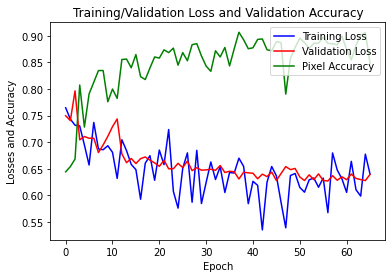

epoch 66, iter 0, loss: 0.6337817907333374
epoch 66, iter 10, loss: 0.5717979073524475
epoch 66, iter 20, loss: 0.6575275659561157
epoch 66, iter 30, loss: 0.6307607889175415
epoch 66, iter 40, loss: 0.5763218402862549
epoch 66, iter 50, loss: 0.5549969673156738
epoch 66, iter 60, loss: 0.5898542404174805
epoch 66, iter 70, loss: 0.6135993003845215
epoch 66, iter 80, loss: 0.5972299575805664
epoch 66, iter 90, loss: 0.6173736453056335
epoch 66, iter 100, loss: 0.6290570497512817
Finished epoch 66, time elapsed: 99.63672399520874
Loss at epoch 66: 0.6218169331550598
IoU at epoch 66: 0.5544520073551725
Pixel acc at epoch 66: 0.9066323701644381
No improvements for 10 rounds.


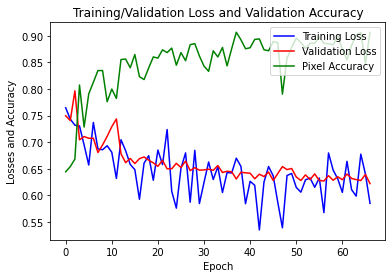

epoch 67, iter 0, loss: 0.5600579977035522
epoch 67, iter 10, loss: 0.567833662033081
epoch 67, iter 20, loss: 0.5013362169265747
epoch 67, iter 30, loss: 0.6080915927886963
epoch 67, iter 40, loss: 0.6158454418182373
epoch 67, iter 50, loss: 0.5150262117385864
epoch 67, iter 60, loss: 0.5634413957595825
epoch 67, iter 70, loss: 0.5696637630462646
epoch 67, iter 80, loss: 0.6290667057037354
epoch 67, iter 90, loss: 0.6219145059585571
epoch 67, iter 100, loss: 0.5686147212982178
Finished epoch 67, time elapsed: 99.75097703933716
Loss at epoch 67: 0.6278496980667114
IoU at epoch 67: 0.5362239666683866
Pixel acc at epoch 67: 0.8882031147431129
No improvements for 11 rounds.


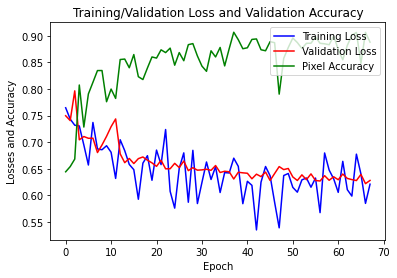

epoch 68, iter 0, loss: 0.6005065441131592
epoch 68, iter 10, loss: 0.5668310523033142
epoch 68, iter 20, loss: 0.6260207891464233
epoch 68, iter 30, loss: 0.5766527652740479
epoch 68, iter 40, loss: 0.5993611812591553
epoch 68, iter 50, loss: 0.5434482097625732
epoch 68, iter 60, loss: 0.542535662651062
epoch 68, iter 70, loss: 0.534536600112915
epoch 68, iter 80, loss: 0.5367556810379028
epoch 68, iter 90, loss: 0.602681040763855
epoch 68, iter 100, loss: 0.6033021211624146
Finished epoch 68, time elapsed: 99.7791440486908
Loss at epoch 68: 0.6387279033660889
IoU at epoch 68: 0.5429001700539406
Pixel acc at epoch 68: 0.8861924396175513
No improvements for 12 rounds.


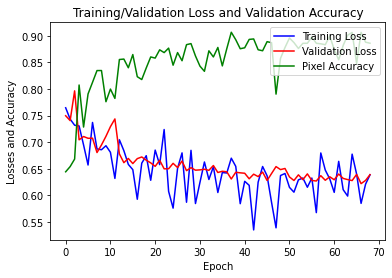

epoch 69, iter 0, loss: 0.5788068175315857
epoch 69, iter 10, loss: 0.56975257396698
epoch 69, iter 20, loss: 0.6338556408882141
epoch 69, iter 30, loss: 0.6141064167022705
epoch 69, iter 40, loss: 0.5533502101898193
epoch 69, iter 50, loss: 0.5936254262924194
epoch 69, iter 60, loss: 0.48968297243118286
epoch 69, iter 70, loss: 0.6053613424301147
epoch 69, iter 80, loss: 0.6373282670974731
epoch 69, iter 90, loss: 0.523338794708252
epoch 69, iter 100, loss: 0.5963720679283142
Finished epoch 69, time elapsed: 99.57922458648682
Loss at epoch 69: 0.6267144680023193
IoU at epoch 69: 0.551699109725927
Pixel acc at epoch 69: 0.9141015750524576
No improvements for 13 rounds.


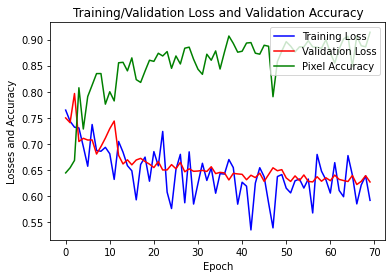

epoch 70, iter 0, loss: 0.6863656044006348
epoch 70, iter 10, loss: 0.5806173086166382
epoch 70, iter 20, loss: 0.5953911542892456
epoch 70, iter 30, loss: 0.6011034250259399
epoch 70, iter 40, loss: 0.6223267316818237
epoch 70, iter 50, loss: 0.654665470123291
epoch 70, iter 60, loss: 0.5041820406913757
epoch 70, iter 70, loss: 0.5547093152999878
epoch 70, iter 80, loss: 0.6203057765960693
epoch 70, iter 90, loss: 0.5205237865447998
epoch 70, iter 100, loss: 0.5588076114654541
Finished epoch 70, time elapsed: 99.63387727737427
Loss at epoch 70: 0.6208248138427734
IoU at epoch 70: 0.5762354028859076
Pixel acc at epoch 70: 0.911008822081355


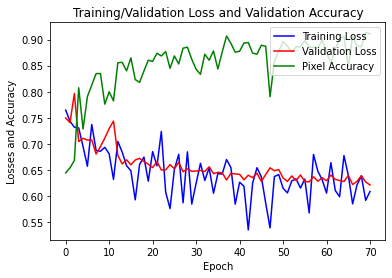

epoch 71, iter 0, loss: 0.5455492734909058
epoch 71, iter 10, loss: 0.6371511220932007
epoch 71, iter 20, loss: 0.6527313590049744
epoch 71, iter 30, loss: 0.5672268867492676
epoch 71, iter 40, loss: 0.5970677137374878
epoch 71, iter 50, loss: 0.5825996398925781
epoch 71, iter 60, loss: 0.5494678020477295
epoch 71, iter 70, loss: 0.5631674528121948
epoch 71, iter 80, loss: 0.6258692741394043
epoch 71, iter 90, loss: 0.7218120098114014
epoch 71, iter 100, loss: 0.5472047328948975
Finished epoch 71, time elapsed: 99.17591547966003
Loss at epoch 71: 0.6401446461677551
IoU at epoch 71: 0.5221397801075502
Pixel acc at epoch 71: 0.879564142121417
No improvements for 1 rounds.


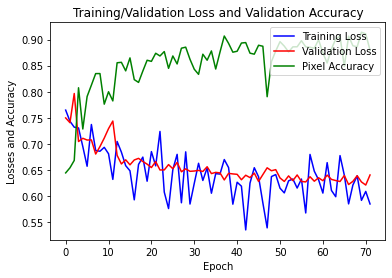

epoch 72, iter 0, loss: 0.6504590511322021
epoch 72, iter 10, loss: 0.5976715087890625
epoch 72, iter 20, loss: 0.5522054433822632
epoch 72, iter 30, loss: 0.6357244849205017
epoch 72, iter 40, loss: 0.5542131662368774
epoch 72, iter 50, loss: 0.642266035079956
epoch 72, iter 60, loss: 0.6091054677963257
epoch 72, iter 70, loss: 0.6420606970787048
epoch 72, iter 80, loss: 0.5703016519546509
epoch 72, iter 90, loss: 0.6410204172134399
epoch 72, iter 100, loss: 0.6203659772872925
Finished epoch 72, time elapsed: 99.17937469482422
Loss at epoch 72: 0.6248171925544739
IoU at epoch 72: 0.5688041543660789
Pixel acc at epoch 72: 0.9054699645028906
No improvements for 2 rounds.


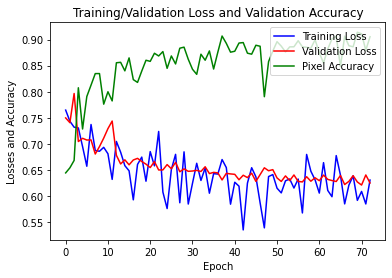

epoch 73, iter 0, loss: 0.586422324180603
epoch 73, iter 10, loss: 0.6007905006408691
epoch 73, iter 20, loss: 0.6734374165534973
epoch 73, iter 30, loss: 0.6349193453788757
epoch 73, iter 40, loss: 0.6062354445457458
epoch 73, iter 50, loss: 0.5984721779823303
epoch 73, iter 60, loss: 0.6389836072921753
epoch 73, iter 70, loss: 0.6521552205085754
epoch 73, iter 80, loss: 0.5534805655479431
epoch 73, iter 90, loss: 0.6119571924209595
epoch 73, iter 100, loss: 0.5789295434951782
Finished epoch 73, time elapsed: 99.21152329444885
Loss at epoch 73: 0.6349152326583862
IoU at epoch 73: 0.5297076813676531
Pixel acc at epoch 73: 0.8675852715858363
No improvements for 3 rounds.


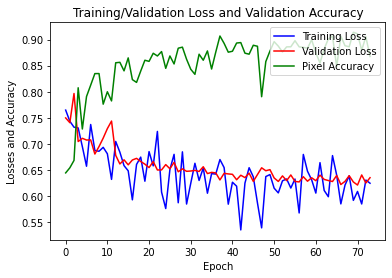

epoch 74, iter 0, loss: 0.6367051601409912
epoch 74, iter 10, loss: 0.6440430879592896
epoch 74, iter 20, loss: 0.6324156522750854
epoch 74, iter 30, loss: 0.5696396827697754
epoch 74, iter 40, loss: 0.6056321859359741
epoch 74, iter 50, loss: 0.5566797256469727
epoch 74, iter 60, loss: 0.5373862981796265
epoch 74, iter 70, loss: 0.5299615859985352
epoch 74, iter 80, loss: 0.5885167717933655
epoch 74, iter 90, loss: 0.5541641712188721
epoch 74, iter 100, loss: 0.5762255787849426
Finished epoch 74, time elapsed: 99.22819972038269
Loss at epoch 74: 0.6294232606887817
IoU at epoch 74: 0.5498585157923691
Pixel acc at epoch 74: 0.8964462980671488
No improvements for 4 rounds.


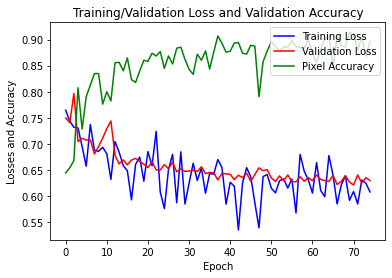

epoch 75, iter 0, loss: 0.5837626457214355
epoch 75, iter 10, loss: 0.5580463409423828
epoch 75, iter 20, loss: 0.5365316867828369
epoch 75, iter 30, loss: 0.5191388130187988
epoch 75, iter 40, loss: 0.6228914260864258
epoch 75, iter 50, loss: 0.6575844287872314
epoch 75, iter 60, loss: 0.6512320041656494
epoch 75, iter 70, loss: 0.6211154460906982
epoch 75, iter 80, loss: 0.5451705455780029
epoch 75, iter 90, loss: 0.5887516736984253
epoch 75, iter 100, loss: 0.5707901120185852
Finished epoch 75, time elapsed: 98.9345235824585
Loss at epoch 75: 0.623781144618988
IoU at epoch 75: 0.5680311110134355
Pixel acc at epoch 75: 0.898869215006811
No improvements for 5 rounds.


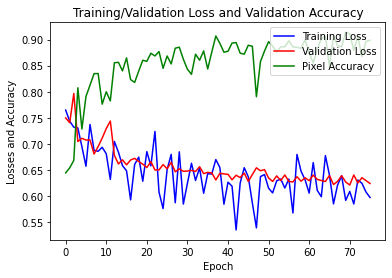

epoch 76, iter 0, loss: 0.5722692012786865
epoch 76, iter 10, loss: 0.6179508566856384
epoch 76, iter 20, loss: 0.5453853607177734
epoch 76, iter 30, loss: 0.5744984149932861
epoch 76, iter 40, loss: 0.6083931922912598
epoch 76, iter 50, loss: 0.6197254657745361
epoch 76, iter 60, loss: 0.5769391059875488
epoch 76, iter 70, loss: 0.6102654933929443
epoch 76, iter 80, loss: 0.5518209338188171
epoch 76, iter 90, loss: 0.6071881055831909
epoch 76, iter 100, loss: 0.6014577150344849
Finished epoch 76, time elapsed: 99.17339754104614
Loss at epoch 76: 0.6259491443634033
IoU at epoch 76: 0.5704887665774696
Pixel acc at epoch 76: 0.9116528008994916
No improvements for 6 rounds.


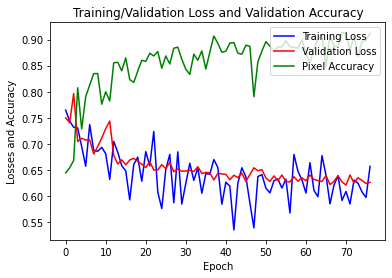

epoch 77, iter 0, loss: 0.6135322451591492
epoch 77, iter 10, loss: 0.5614267587661743
epoch 77, iter 20, loss: 0.4853675365447998
epoch 77, iter 30, loss: 0.591011643409729
epoch 77, iter 40, loss: 0.5602813959121704
epoch 77, iter 50, loss: 0.6156648397445679
epoch 77, iter 60, loss: 0.5989477038383484
epoch 77, iter 70, loss: 0.5597399473190308
epoch 77, iter 80, loss: 0.5645167827606201
epoch 77, iter 90, loss: 0.6034146547317505
epoch 77, iter 100, loss: 0.6154266595840454
Finished epoch 77, time elapsed: 99.08186769485474
Loss at epoch 77: 0.6255184412002563
IoU at epoch 77: 0.5629955162483762
Pixel acc at epoch 77: 0.9086682835164186
No improvements for 7 rounds.


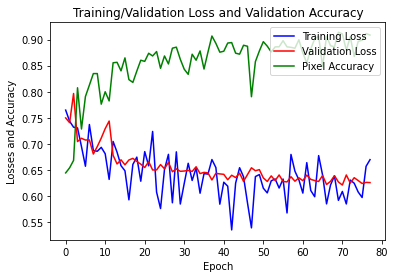

epoch 78, iter 0, loss: 0.5203306078910828
epoch 78, iter 10, loss: 0.5039780139923096
epoch 78, iter 20, loss: 0.5990227460861206
epoch 78, iter 30, loss: 0.5422801971435547
epoch 78, iter 40, loss: 0.5987915992736816
epoch 78, iter 50, loss: 0.5710815191268921
epoch 78, iter 60, loss: 0.590106189250946
epoch 78, iter 70, loss: 0.6386004686355591
epoch 78, iter 80, loss: 0.609076738357544
epoch 78, iter 90, loss: 0.6347259283065796
epoch 78, iter 100, loss: 0.553375244140625
Finished epoch 78, time elapsed: 99.18340158462524
Loss at epoch 78: 0.6181333065032959
IoU at epoch 78: 0.5844955789338077
Pixel acc at epoch 78: 0.923001890691948


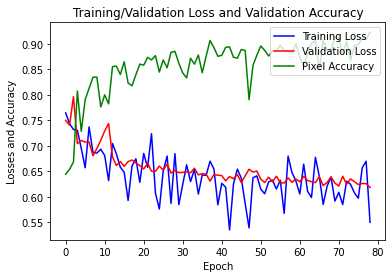

epoch 79, iter 0, loss: 0.5596269369125366
epoch 79, iter 10, loss: 0.579749584197998
epoch 79, iter 20, loss: 0.6151000261306763
epoch 79, iter 30, loss: 0.5285687446594238
epoch 79, iter 40, loss: 0.5195809602737427
epoch 79, iter 50, loss: 0.6698215007781982
epoch 79, iter 60, loss: 0.5564457178115845
epoch 79, iter 70, loss: 0.5875638127326965
epoch 79, iter 80, loss: 0.6212822198867798
epoch 79, iter 90, loss: 0.5764786005020142
epoch 79, iter 100, loss: 0.5592870712280273
Finished epoch 79, time elapsed: 99.20329356193542
Loss at epoch 79: 0.6229078769683838
IoU at epoch 79: 0.5516223564353033
Pixel acc at epoch 79: 0.902742679819415
No improvements for 1 rounds.


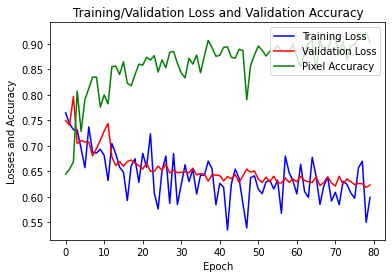

epoch 80, iter 0, loss: 0.6529102325439453
epoch 80, iter 10, loss: 0.5939488410949707
epoch 80, iter 20, loss: 0.5354450941085815
epoch 80, iter 30, loss: 0.5797042846679688
epoch 80, iter 40, loss: 0.6009018421173096
epoch 80, iter 50, loss: 0.5297481417655945
epoch 80, iter 60, loss: 0.566484808921814
epoch 80, iter 70, loss: 0.6170303225517273
epoch 80, iter 80, loss: 0.6602128148078918
epoch 80, iter 90, loss: 0.5277754068374634
epoch 80, iter 100, loss: 0.5092724561691284
Finished epoch 80, time elapsed: 99.142254114151
Loss at epoch 80: 0.6256780028343201
IoU at epoch 80: 0.554681134570148
Pixel acc at epoch 80: 0.9064611369209212
No improvements for 2 rounds.


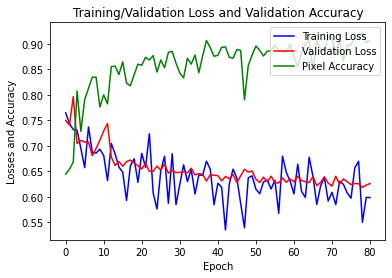

epoch 81, iter 0, loss: 0.5512222647666931
epoch 81, iter 10, loss: 0.6027181148529053
epoch 81, iter 20, loss: 0.6213318109512329
epoch 81, iter 30, loss: 0.59479820728302
epoch 81, iter 40, loss: 0.5361620187759399
epoch 81, iter 50, loss: 0.6614856123924255
epoch 81, iter 60, loss: 0.5831254720687866
epoch 81, iter 70, loss: 0.6013526916503906
epoch 81, iter 80, loss: 0.5996410846710205
epoch 81, iter 90, loss: 0.5834340453147888
epoch 81, iter 100, loss: 0.5644895434379578
Finished epoch 81, time elapsed: 99.18866395950317
Loss at epoch 81: 0.6305966973304749
IoU at epoch 81: 0.5502600035287463
Pixel acc at epoch 81: 0.8961006994499097
No improvements for 3 rounds.


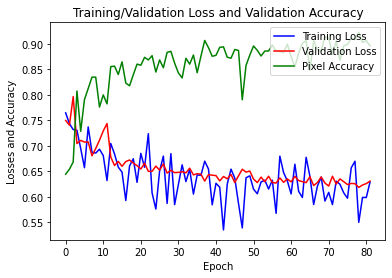

epoch 82, iter 0, loss: 0.48498421907424927
epoch 82, iter 10, loss: 0.5947803258895874
epoch 82, iter 20, loss: 0.5559521913528442
epoch 82, iter 30, loss: 0.5501157641410828
epoch 82, iter 40, loss: 0.5344123840332031
epoch 82, iter 50, loss: 0.5912564992904663
epoch 82, iter 60, loss: 0.586259126663208
epoch 82, iter 70, loss: 0.6076980829238892
epoch 82, iter 80, loss: 0.5212277173995972
epoch 82, iter 90, loss: 0.5829936265945435
epoch 82, iter 100, loss: 0.5944388508796692
Finished epoch 82, time elapsed: 99.1843490600586
Loss at epoch 82: 0.6300017833709717
IoU at epoch 82: 0.5440370947735155
Pixel acc at epoch 82: 0.8950699397776857
No improvements for 4 rounds.


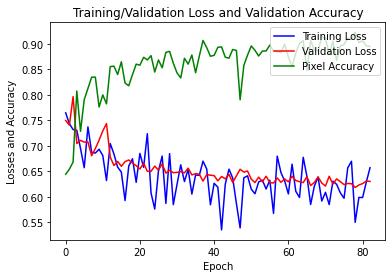

epoch 83, iter 0, loss: 0.6057742238044739
epoch 83, iter 10, loss: 0.6129337549209595
epoch 83, iter 20, loss: 0.5762554407119751
epoch 83, iter 30, loss: 0.561731219291687
epoch 83, iter 40, loss: 0.5986545085906982
epoch 83, iter 50, loss: 0.5582627058029175
epoch 83, iter 60, loss: 0.562402069568634
epoch 83, iter 70, loss: 0.5949224233627319
epoch 83, iter 80, loss: 0.7184051871299744
epoch 83, iter 90, loss: 0.570935845375061
epoch 83, iter 100, loss: 0.5156462788581848
Finished epoch 83, time elapsed: 99.08620119094849
Loss at epoch 83: 0.6329053044319153
IoU at epoch 83: 0.5143709834591139
Pixel acc at epoch 83: 0.8954913452481719
No improvements for 5 rounds.


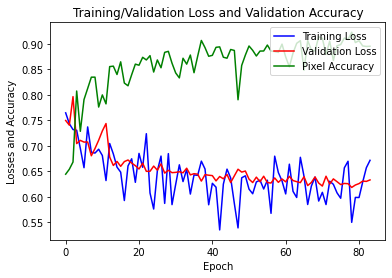

epoch 84, iter 0, loss: 0.5967528820037842
epoch 84, iter 10, loss: 0.5243197083473206
epoch 84, iter 20, loss: 0.516643226146698
epoch 84, iter 30, loss: 0.5905849933624268
epoch 84, iter 40, loss: 0.5742011070251465
epoch 84, iter 50, loss: 0.6427367925643921
epoch 84, iter 60, loss: 0.5900828838348389
epoch 84, iter 70, loss: 0.5356037616729736
epoch 84, iter 80, loss: 0.584769606590271
epoch 84, iter 90, loss: 0.5783683061599731
epoch 84, iter 100, loss: 0.54903244972229
Finished epoch 84, time elapsed: 99.05622696876526
Loss at epoch 84: 0.6304236054420471
IoU at epoch 84: 0.5301226448659873
Pixel acc at epoch 84: 0.8532502896734073
No improvements for 6 rounds.


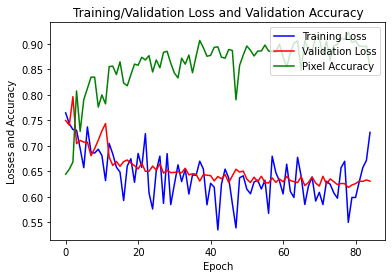

epoch 85, iter 0, loss: 0.5658040046691895
epoch 85, iter 10, loss: 0.5974732041358948
epoch 85, iter 20, loss: 0.6640689373016357
epoch 85, iter 30, loss: 0.5233192443847656
epoch 85, iter 40, loss: 0.603561282157898
epoch 85, iter 50, loss: 0.5677512884140015
epoch 85, iter 60, loss: 0.5581415891647339
epoch 85, iter 70, loss: 0.5956865549087524
epoch 85, iter 80, loss: 0.592157244682312
epoch 85, iter 90, loss: 0.5841473340988159
epoch 85, iter 100, loss: 0.6272506713867188
Finished epoch 85, time elapsed: 99.26331949234009
Loss at epoch 85: 0.6218897104263306
IoU at epoch 85: 0.5513251441917881
Pixel acc at epoch 85: 0.9083586268568844
No improvements for 7 rounds.


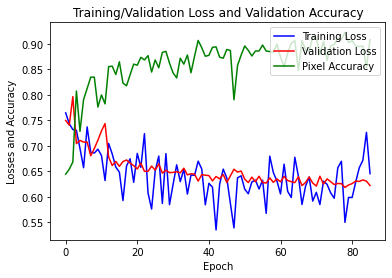

epoch 86, iter 0, loss: 0.5992165803909302
epoch 86, iter 10, loss: 0.5533953905105591
epoch 86, iter 20, loss: 0.6403589844703674
epoch 86, iter 30, loss: 0.5523167848587036
epoch 86, iter 40, loss: 0.5772149562835693
epoch 86, iter 50, loss: 0.6066359281539917
epoch 86, iter 60, loss: 0.603683352470398
epoch 86, iter 70, loss: 0.5526885986328125
epoch 86, iter 80, loss: 0.5553783178329468
epoch 86, iter 90, loss: 0.6061618328094482
epoch 86, iter 100, loss: 0.5548744201660156
Finished epoch 86, time elapsed: 99.17172336578369
Loss at epoch 86: 0.6220811605453491
IoU at epoch 86: 0.5641710880687122
Pixel acc at epoch 86: 0.8998328559794414
No improvements for 8 rounds.


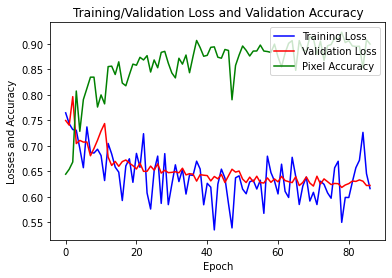

epoch 87, iter 0, loss: 0.6188907623291016
epoch 87, iter 10, loss: 0.6326825618743896
epoch 87, iter 20, loss: 0.5867152810096741
epoch 87, iter 30, loss: 0.6235330104827881
epoch 87, iter 40, loss: 0.5491066575050354
epoch 87, iter 50, loss: 0.5856119394302368
epoch 87, iter 60, loss: 0.5297644138336182
epoch 87, iter 70, loss: 0.5708089470863342
epoch 87, iter 80, loss: 0.5529462099075317
epoch 87, iter 90, loss: 0.6007434129714966
epoch 87, iter 100, loss: 0.6348894834518433
Finished epoch 87, time elapsed: 99.158855676651
Loss at epoch 87: 0.6244836449623108
IoU at epoch 87: 0.5455443490540185
Pixel acc at epoch 87: 0.8815191469985593
No improvements for 9 rounds.


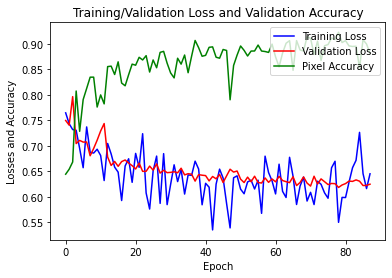

epoch 88, iter 0, loss: 0.5319443941116333
epoch 88, iter 10, loss: 0.561774730682373
epoch 88, iter 20, loss: 0.537333607673645
epoch 88, iter 30, loss: 0.6975110173225403
epoch 88, iter 40, loss: 0.5420739650726318
epoch 88, iter 50, loss: 0.6565651297569275
epoch 88, iter 60, loss: 0.5559334754943848
epoch 88, iter 70, loss: 0.6143180727958679
epoch 88, iter 80, loss: 0.691588282585144
epoch 88, iter 90, loss: 0.5497502088546753
epoch 88, iter 100, loss: 0.5744417905807495
Finished epoch 88, time elapsed: 99.15556979179382
Loss at epoch 88: 0.6178894639015198
IoU at epoch 88: 0.5723750683663499
Pixel acc at epoch 88: 0.9105578669349051
No improvements for 10 rounds.


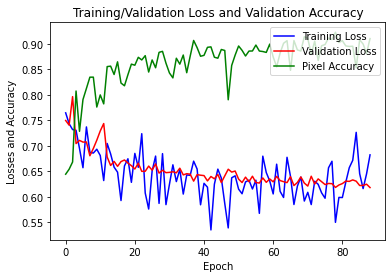

epoch 89, iter 0, loss: 0.6248682737350464
epoch 89, iter 10, loss: 0.6062158346176147
epoch 89, iter 20, loss: 0.6060323715209961
epoch 89, iter 30, loss: 0.5839470624923706
epoch 89, iter 40, loss: 0.6238963603973389
epoch 89, iter 50, loss: 0.6044619083404541
epoch 89, iter 60, loss: 0.5929398536682129
epoch 89, iter 70, loss: 0.6226593255996704
epoch 89, iter 80, loss: 0.6139272451400757
epoch 89, iter 90, loss: 0.5619427561759949
epoch 89, iter 100, loss: 0.6441313028335571
Finished epoch 89, time elapsed: 99.28023195266724
Loss at epoch 89: 0.6225064992904663
IoU at epoch 89: 0.5719416918937175
Pixel acc at epoch 89: 0.9033681349297296
No improvements for 11 rounds.


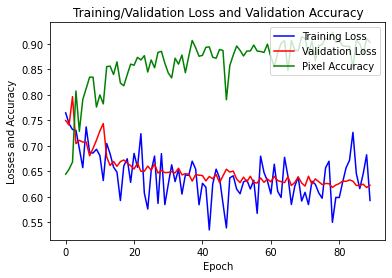

epoch 90, iter 0, loss: 0.6100846529006958
epoch 90, iter 10, loss: 0.6041693687438965
epoch 90, iter 20, loss: 0.5767639875411987
epoch 90, iter 30, loss: 0.6115002632141113
epoch 90, iter 40, loss: 0.5891023874282837
epoch 90, iter 50, loss: 0.5846366882324219
epoch 90, iter 60, loss: 0.5648860931396484
epoch 90, iter 70, loss: 0.619480550289154
epoch 90, iter 80, loss: 0.6202255487442017
epoch 90, iter 90, loss: 0.5691341161727905
epoch 90, iter 100, loss: 0.5963706970214844
Finished epoch 90, time elapsed: 99.35007381439209
Loss at epoch 90: 0.6180064082145691
IoU at epoch 90: 0.586337120110045
Pixel acc at epoch 90: 0.9117811790977974


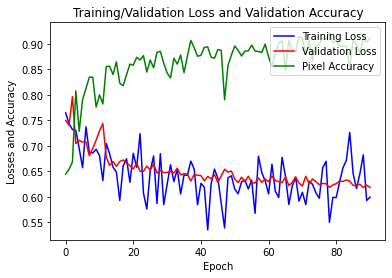

epoch 91, iter 0, loss: 0.6033384203910828
epoch 91, iter 10, loss: 0.5894066095352173
epoch 91, iter 20, loss: 0.5327168703079224
epoch 91, iter 30, loss: 0.6325827836990356
epoch 91, iter 40, loss: 0.5266088247299194
epoch 91, iter 50, loss: 0.5582676529884338
epoch 91, iter 60, loss: 0.5477536916732788
epoch 91, iter 70, loss: 0.6260479688644409
epoch 91, iter 80, loss: 0.5525169372558594
epoch 91, iter 90, loss: 0.6255806088447571
epoch 91, iter 100, loss: 0.5994113683700562
Finished epoch 91, time elapsed: 99.33297324180603
Loss at epoch 91: 0.6231282949447632
IoU at epoch 91: 0.5517568427744615
Pixel acc at epoch 91: 0.9012869016885703
No improvements for 1 rounds.


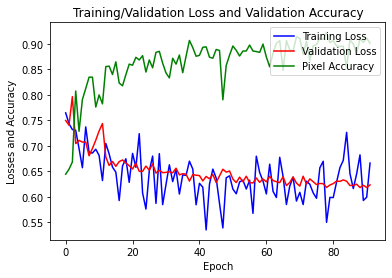

epoch 92, iter 0, loss: 0.6248940229415894
epoch 92, iter 10, loss: 0.5344208478927612
epoch 92, iter 20, loss: 0.5836688280105591
epoch 92, iter 30, loss: 0.5804346799850464
epoch 92, iter 40, loss: 0.5829673409461975
epoch 92, iter 50, loss: 0.5908842086791992
epoch 92, iter 60, loss: 0.5873374938964844
epoch 92, iter 70, loss: 0.6517332792282104
epoch 92, iter 80, loss: 0.5812636017799377
epoch 92, iter 90, loss: 0.5637819766998291
epoch 92, iter 100, loss: 0.6346923112869263
Finished epoch 92, time elapsed: 99.76037764549255
Loss at epoch 92: 0.6285592317581177
IoU at epoch 92: 0.5503941148228514
Pixel acc at epoch 92: 0.9067431659217142
No improvements for 2 rounds.


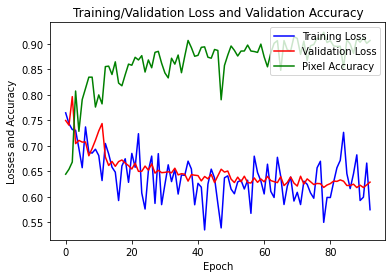

epoch 93, iter 0, loss: 0.5244308710098267
epoch 93, iter 10, loss: 0.5659447908401489
epoch 93, iter 20, loss: 0.632267415523529
epoch 93, iter 30, loss: 0.6853525638580322
epoch 93, iter 40, loss: 0.6144635677337646
epoch 93, iter 50, loss: 0.5613111257553101
epoch 93, iter 60, loss: 0.5574690103530884
epoch 93, iter 70, loss: 0.5542285442352295
epoch 93, iter 80, loss: 0.6003236770629883
epoch 93, iter 90, loss: 0.5892733335494995
epoch 93, iter 100, loss: 0.6229711771011353
Finished epoch 93, time elapsed: 99.48612785339355
Loss at epoch 93: 0.6247101426124573
IoU at epoch 93: 0.5562960180435252
Pixel acc at epoch 93: 0.9004358296609729
No improvements for 3 rounds.


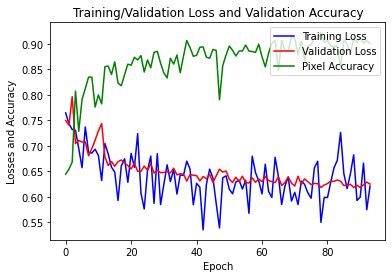

epoch 94, iter 0, loss: 0.5576815009117126
epoch 94, iter 10, loss: 0.5116952657699585
epoch 94, iter 20, loss: 0.5971958637237549
epoch 94, iter 30, loss: 0.570979654788971
epoch 94, iter 40, loss: 0.5661766529083252
epoch 94, iter 50, loss: 0.5794451832771301
epoch 94, iter 60, loss: 0.6411985158920288
epoch 94, iter 70, loss: 0.6255370378494263
epoch 94, iter 80, loss: 0.5823699235916138
epoch 94, iter 90, loss: 0.4962567090988159
epoch 94, iter 100, loss: 0.5904453992843628
Finished epoch 94, time elapsed: 99.15624189376831
Loss at epoch 94: 0.6219397783279419
IoU at epoch 94: 0.5710510797034035
Pixel acc at epoch 94: 0.9170633433393445
No improvements for 4 rounds.


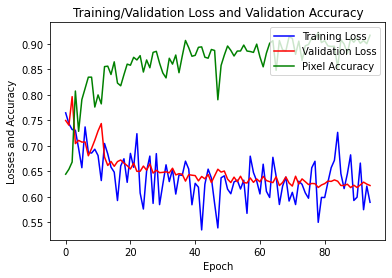

epoch 95, iter 0, loss: 0.5893716812133789
epoch 95, iter 10, loss: 0.5466681718826294
epoch 95, iter 20, loss: 0.5687291622161865
epoch 95, iter 30, loss: 0.5919568538665771
epoch 95, iter 40, loss: 0.6613182425498962
epoch 95, iter 50, loss: 0.5820402503013611
epoch 95, iter 60, loss: 0.5552595853805542
epoch 95, iter 70, loss: 0.5541285276412964
epoch 95, iter 80, loss: 0.6683570146560669
epoch 95, iter 90, loss: 0.6233323216438293
epoch 95, iter 100, loss: 0.5524027347564697
Finished epoch 95, time elapsed: 99.383141040802
Loss at epoch 95: 0.6168955564498901
IoU at epoch 95: 0.5610443150021971
Pixel acc at epoch 95: 0.9120294598923183
No improvements for 5 rounds.


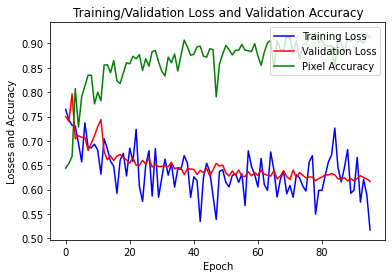

epoch 96, iter 0, loss: 0.5659722089767456
epoch 96, iter 10, loss: 0.5501986742019653
epoch 96, iter 20, loss: 0.6116100549697876
epoch 96, iter 30, loss: 0.5859050154685974
epoch 96, iter 40, loss: 0.5916751623153687
epoch 96, iter 50, loss: 0.5621964335441589
epoch 96, iter 60, loss: 0.5917436480522156
epoch 96, iter 70, loss: 0.504164457321167
epoch 96, iter 80, loss: 0.5401893854141235
epoch 96, iter 90, loss: 0.5996291637420654
epoch 96, iter 100, loss: 0.5778393745422363
Finished epoch 96, time elapsed: 99.64068341255188
Loss at epoch 96: 0.617648184299469
IoU at epoch 96: 0.5788757224288534
Pixel acc at epoch 96: 0.908250078851059
No improvements for 6 rounds.


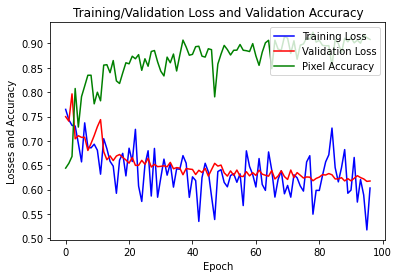

epoch 97, iter 0, loss: 0.5975987911224365
epoch 97, iter 10, loss: 0.5785722732543945
epoch 97, iter 20, loss: 0.5889199376106262
epoch 97, iter 30, loss: 0.6131304502487183
epoch 97, iter 40, loss: 0.5935761332511902
epoch 97, iter 50, loss: 0.5986957550048828
epoch 97, iter 60, loss: 0.5172657370567322
epoch 97, iter 70, loss: 0.5145748853683472
epoch 97, iter 80, loss: 0.6212902069091797
epoch 97, iter 90, loss: 0.5931051969528198
epoch 97, iter 100, loss: 0.574230432510376
Finished epoch 97, time elapsed: 99.1225233078003
Loss at epoch 97: 0.6219233274459839
IoU at epoch 97: 0.5627586823764517
Pixel acc at epoch 97: 0.9210098707902014
No improvements for 7 rounds.


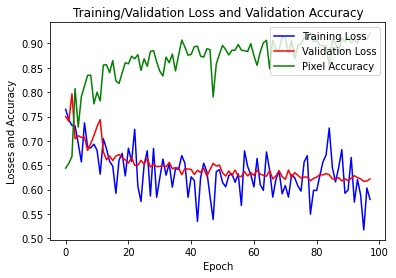

epoch 98, iter 0, loss: 0.6385890245437622
epoch 98, iter 10, loss: 0.5629624128341675
epoch 98, iter 20, loss: 0.5719356536865234
epoch 98, iter 30, loss: 0.5843396782875061
epoch 98, iter 40, loss: 0.5527685880661011
epoch 98, iter 50, loss: 0.555841326713562
epoch 98, iter 60, loss: 0.5334410071372986
epoch 98, iter 70, loss: 0.6208330392837524
epoch 98, iter 80, loss: 0.552839994430542
epoch 98, iter 90, loss: 0.6103570461273193
epoch 98, iter 100, loss: 0.5548313856124878
Finished epoch 98, time elapsed: 99.11041641235352
Loss at epoch 98: 0.6192790269851685
IoU at epoch 98: 0.5683056174829997
Pixel acc at epoch 98: 0.9087061123714276
No improvements for 8 rounds.


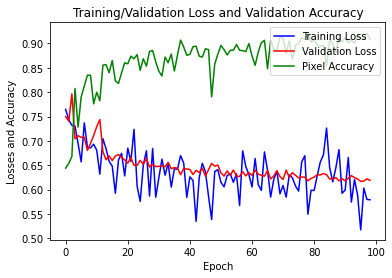

epoch 99, iter 0, loss: 0.5787409543991089
epoch 99, iter 10, loss: 0.5722130537033081
epoch 99, iter 20, loss: 0.6024720668792725
epoch 99, iter 30, loss: 0.5674481391906738
epoch 99, iter 40, loss: 0.5481255054473877
epoch 99, iter 50, loss: 0.65975421667099
epoch 99, iter 60, loss: 0.5799843668937683
epoch 99, iter 70, loss: 0.571969747543335
epoch 99, iter 80, loss: 0.5611543655395508
epoch 99, iter 90, loss: 0.534784197807312
epoch 99, iter 100, loss: 0.5500578880310059
Finished epoch 99, time elapsed: 99.18963074684143
Loss at epoch 99: 0.6234448552131653
IoU at epoch 99: 0.5601834325969544
Pixel acc at epoch 99: 0.9130990371197153
No improvements for 9 rounds.


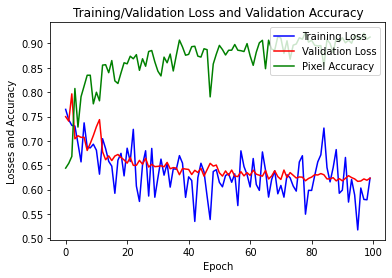

In [ ]:
#val(0)  # show the accuracy before training
train_loss, val_loss, accs = train()

#For graphing

In [ ]:
#For graphing

import matplotlib.pyplot as plt
import numpy as np

def graph_loss(title, training_filename, validation_filename, mode = 'npy'):
    if mode == 'npy':
        training_loss = np.load(training_filename)
        validation_loss = np.load(validation_filename)
    else:
        training_loss = np.genfromtxt(training_filename,delimiter=',')
        validation_loss = np.genfromtxt(validation_filename,delimiter=',')

    plt.plot(training_loss,"-b", label="Training Loss")
    plt.plot(validation_loss,"-r", label="Validation Loss")
    plt.locator_params(axis="x", integer=True, tight=True)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title + " Training and Validation Loss")
    plt.legend(loc="upper right")
    plt.savefig(title + ' Loss.png', bbox_inches='tight')
    plt.clf()

if __name__ == "__main__":
    graph_loss("U-Net", 'unet_trainloss_1.csv', "unet_valloss_1.csv", 'csv')

OSError: ignored

#Run this to get samples per class

In [ ]:
#from dataloader import *
import PIL

train_dataset = TASDataset('/content/drive/MyDrive/coding_review/data/tas500v1.1')

paths = train_dataset.paths
sample_per_class = np.zeros(10)

for ind in range(len(paths)):
    mask_image = np.asarray(PIL.Image.open(paths[ind][1]).resize((train_dataset.width, train_dataset.height), PIL.Image.NEAREST))
    mask =  rgb2val(mask_image, train_dataset.color2class)
    for c in range(10):
        sample_per_class[c] = sample_per_class[c] + np.sum(mask==c)

# Save the number of samples per class.
np.save('sample_per_class (2).npy', sample_per_class)